# Import bibliotek

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cinic_directory_train = 'D:\\GitHub\\CINIC-10\\train'
cinic_directory_test = 'D:\\GitHub\\CINIC-10\\test' 
cinic_directory_val = 'D:\\GitHub\\CINIC-10\\valid'

SEED = 1337

tf.random.set_seed(SEED)

optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
#metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')] 

c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

# Funkcje pomocnicze

In [2]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

In [3]:
def create_model1(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [4]:
def create_model2(num_classes):
    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(LayerNormalization())
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [5]:
def create_model3(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=1024))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model

In [6]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

In [7]:
def show_confusion_matrix_without_names(model, test_ds, num_classes):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy())
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

# Wczytanie danych

In [8]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [9]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [10]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [11]:
class_names= train_ds.class_names
num_classes = len(class_names)

print(class_names)

metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')]
metrics2 = ['categorical_accuracy','auc','precision','recall', 'f1_score']

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [13]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    # horizontal_flip=True,  # randomly flip images
    # vertical_flip=False,
    # brightness_range = [0.9,1.1],
    # channel_shift_range = 50
    )
datagen_valid = ImageDataGenerator(rescale=1./255)

In [14]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    cinic_directory_train,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    cinic_directory_val,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    cinic_directory_test,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


# Architektura pierwszego modelu

In [15]:
model1 = create_model1(num_classes)

In [16]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [17]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                        

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 166s 28ms/step - loss: 1.6227 - categorical_accuracy: 0.4149 - auc: 0.8471 - precision: 0.5866 - recall: 0.2211 - f1_score: 0.2993 - val_loss: 1.4054 - val_categorical_accuracy: 0.4847 - val_auc: 0.8875 - val_precision: 0.6548 - val_recall: 0.3173 - val_f1_score: 0.3925
Epoch 2/20
5625/5625 [==============================] - 121s 21ms/step - loss: 1.3358 - categorical_accuracy: 0.5175 - auc: 0.8978 - precision: 0.6859 - recall: 0.3398 - f1_score: 0.4283 - val_loss: 1.4194 - val_categorical_accuracy: 0.5117 - val_auc: 0.8854 - val_precision: 0.6702 - val_recall: 0.3774 - val_f1_score: 0.4209
Epoch 3/20
5625/5625 [==============================] - 121s 21ms/step - loss: 1.2432 - categorical_accuracy: 0.5524 - auc: 0.9118 - precision: 0.7125 - recall: 0.3911 - f1_score: 0.4820 - val_loss: 1.4820 - val_categorical_accuracy: 0.4851 - val_auc: 0.8819 - val_precision: 0.5861 - val_recall: 0.3686 - val_f1_score: 0.4072
Epoch 4/20
5625/562

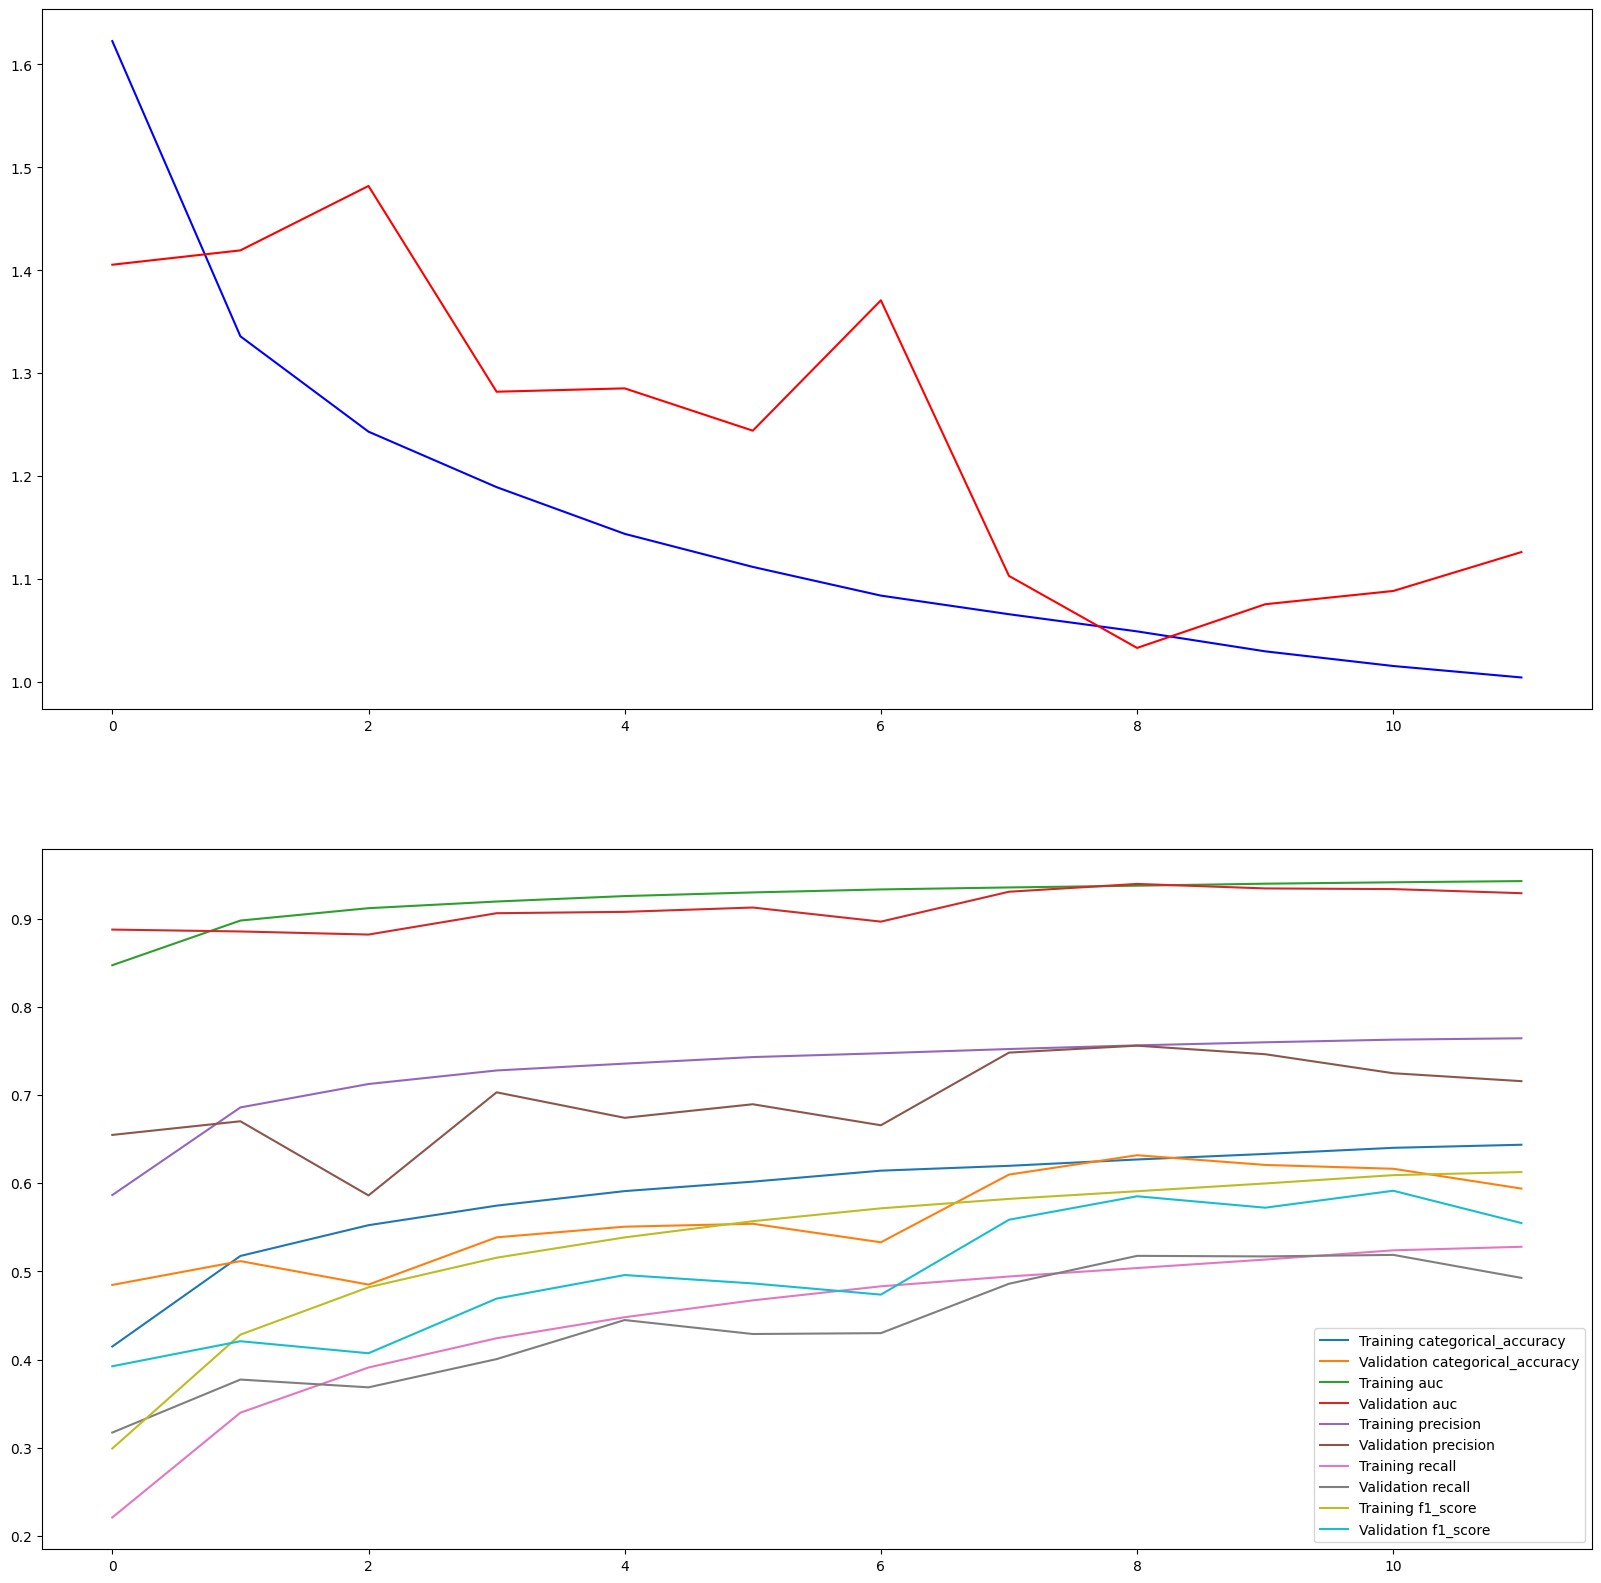

In [19]:
show_training_validation_loss_and_metrics(model1,metrics2)

In [20]:
model1.evaluate(test_it)

5625/5625 [==============================] - 61s 11ms/step - loss: 1.1328 - categorical_accuracy: 0.5933 - auc: 0.9279 - precision: 0.7141 - recall: 0.4906 - f1_score: 0.5534


[1.132781982421875,
 0.593322217464447,
 0.9279400110244751,
 0.7141239643096924,
 0.49061110615730286,
 0.5534183979034424]

5625/5625 [==============================] - 19s 3ms/step


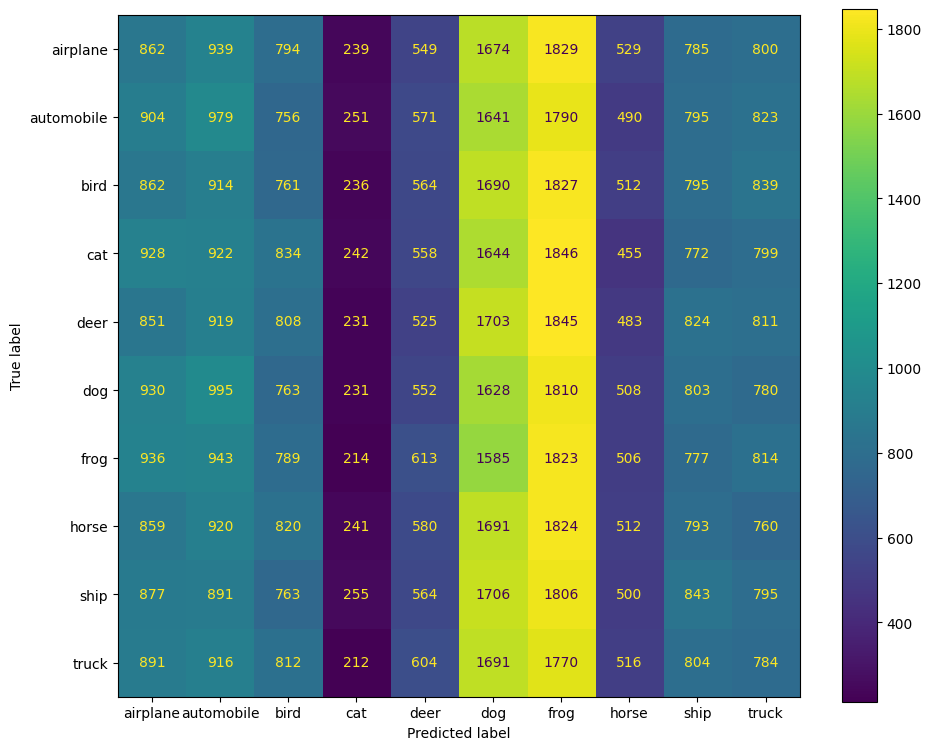

In [21]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


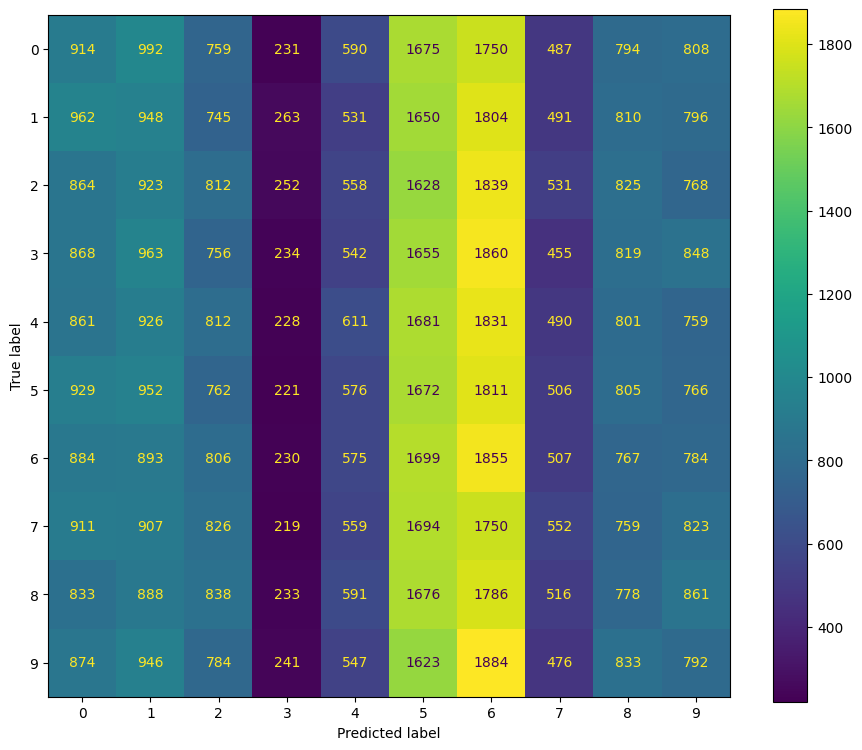

In [22]:
show_confusion_matrix_without_names(model1,test_ds,num_classes)

# Architektura drugiego modelu

In [23]:
model2 = create_model2(num_classes)

In [24]:
model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization (LayerN  (None, 32, 32, 75)       150       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 75)       0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_1 (Laye  (None, 16, 16, 50)       100       
 rNormalization)                                                 
                                                      

In [26]:
history = model2.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.7801 - categorical_accuracy: 0.3502 - auc: 0.8071 - precision: 0.5822 - recall: 0.1173 - f1_score: 0.4004 - val_loss: 1.5562 - val_categorical_accuracy: 0.4272 - val_auc: 0.8589 - val_precision: 0.6081 - val_recall: 0.2294 - val_f1_score: 0.2881
Epoch 2/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.4952 - categorical_accuracy: 0.4520 - auc: 0.8703 - precision: 0.6580 - recall: 0.2325 - f1_score: 0.3147 - val_loss: 1.4448 - val_categorical_accuracy: 0.4767 - val_auc: 0.8807 - val_precision: 0.6389 - val_recall: 0.3041 - val_f1_score: 0.3671
Epoch 3/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.4064 - categorical_accuracy: 0.4872 - auc: 0.8861 - precision: 0.6795 - recall: 0.2864 - f1_score: 0.3738 - val_loss: 1.3217 - val_categorical_accuracy: 0.5201 - val_auc: 0.9002 - val_precision: 0.7043 - val_recall: 0.3204 - val_f1_score: 0.4042
Epoch 4/20
5625/562

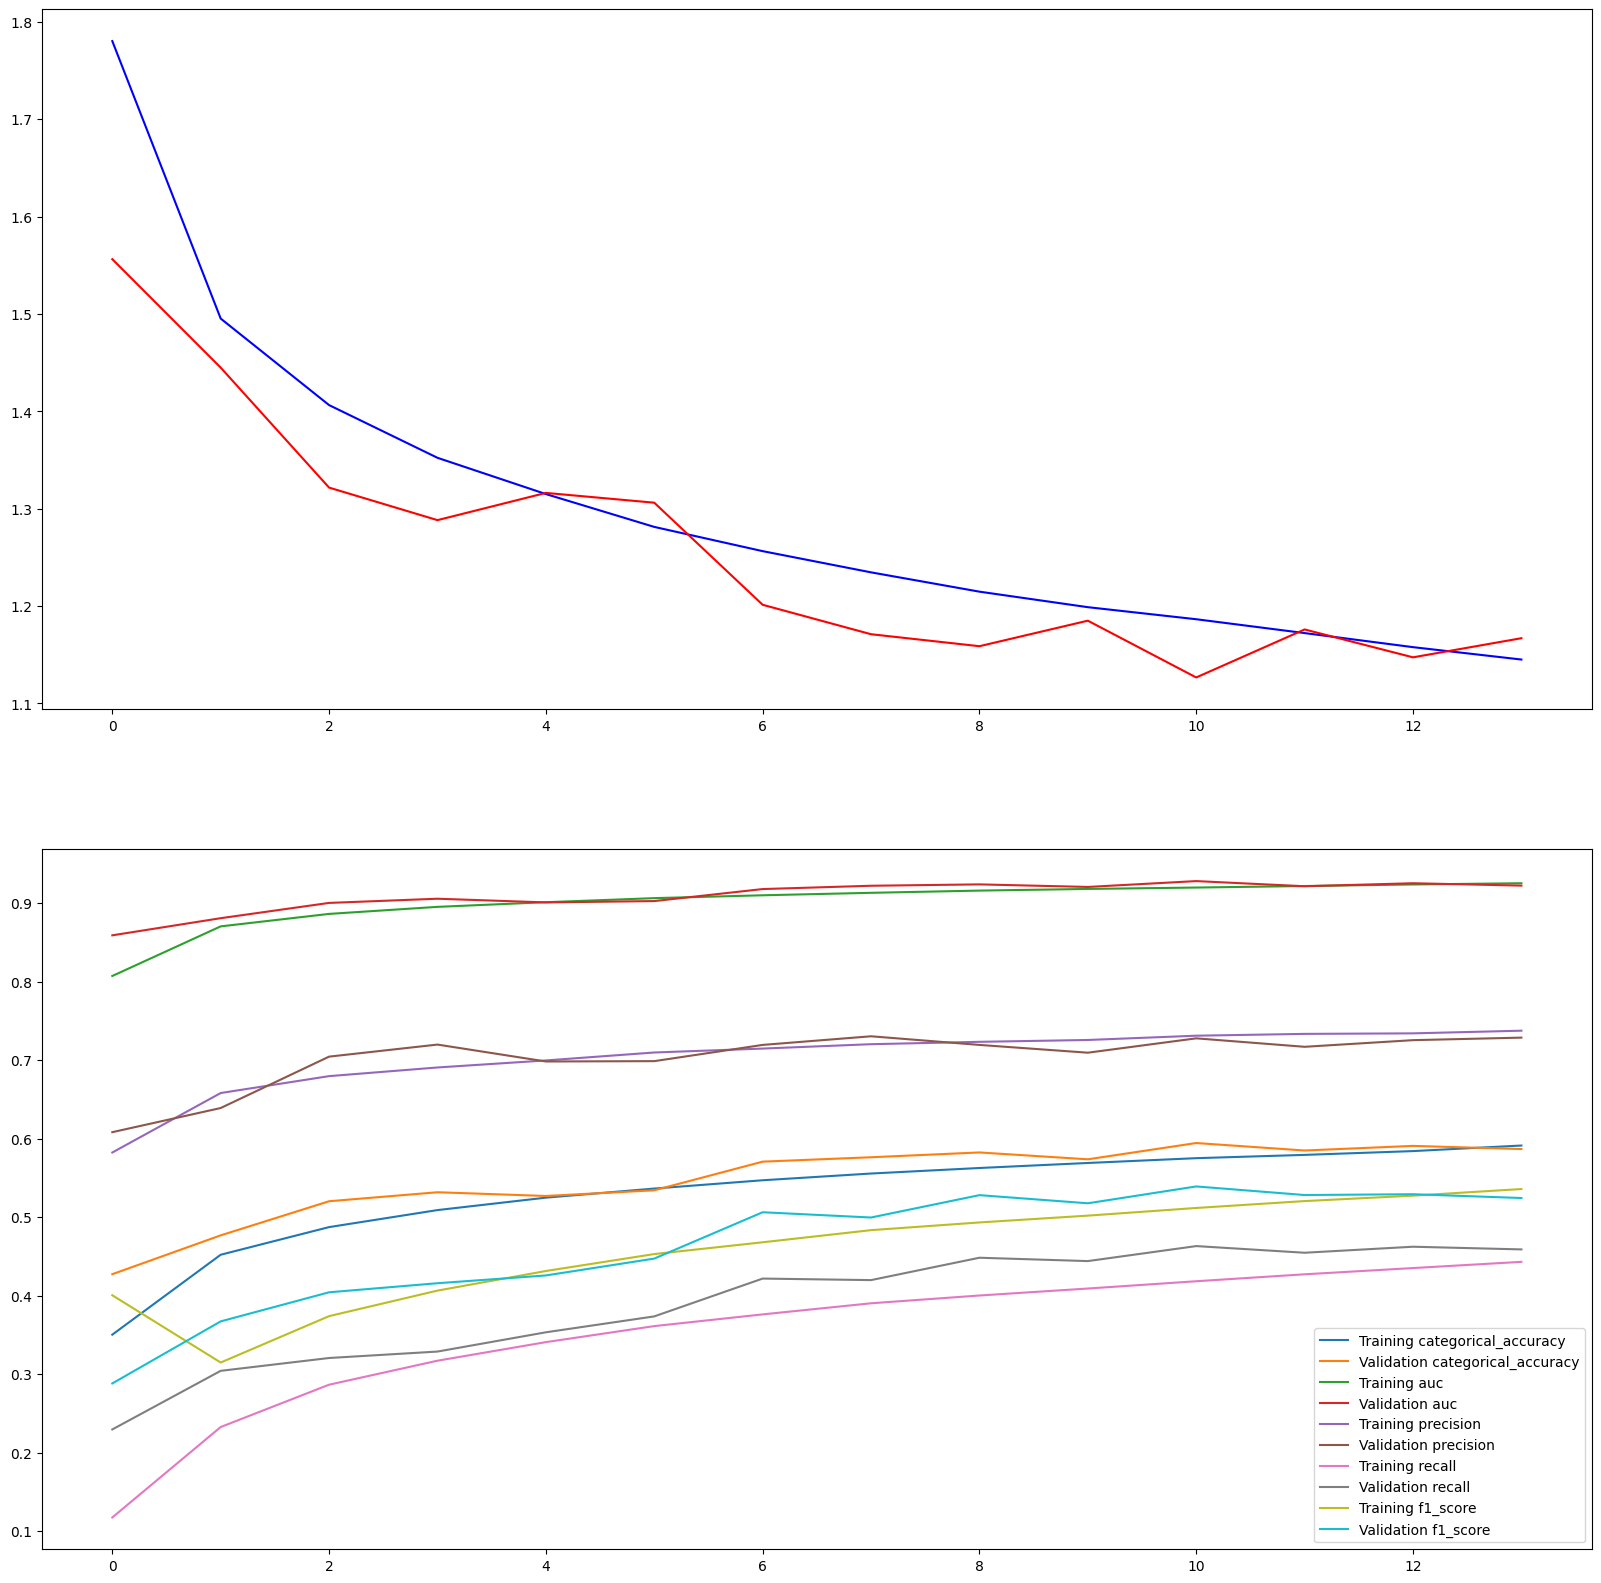

In [27]:
show_training_validation_loss_and_metrics(model2,metrics2)

In [28]:
model2.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.1762 - categorical_accuracy: 0.5839 - auc: 0.9209 - precision: 0.7275 - recall: 0.4557 - f1_score: 0.5215


[1.17622971534729,
 0.5839444398880005,
 0.9209402203559875,
 0.7275323867797852,
 0.4556777775287628,
 0.521543025970459]

5625/5625 [==============================] - 22s 4ms/step


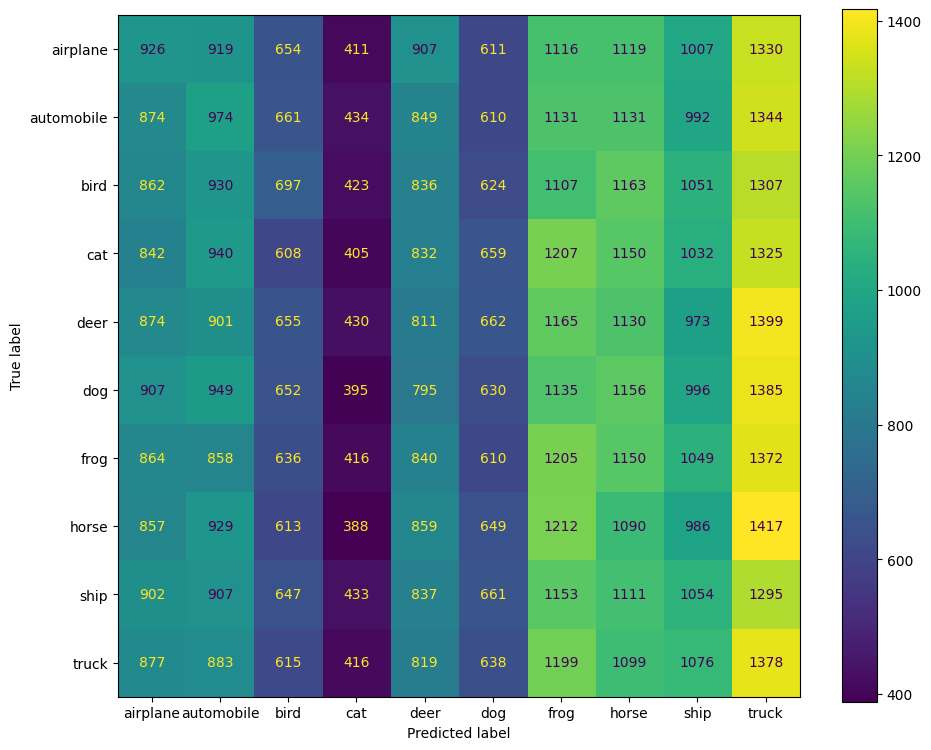

In [29]:
show_confusion_matrix(model2,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


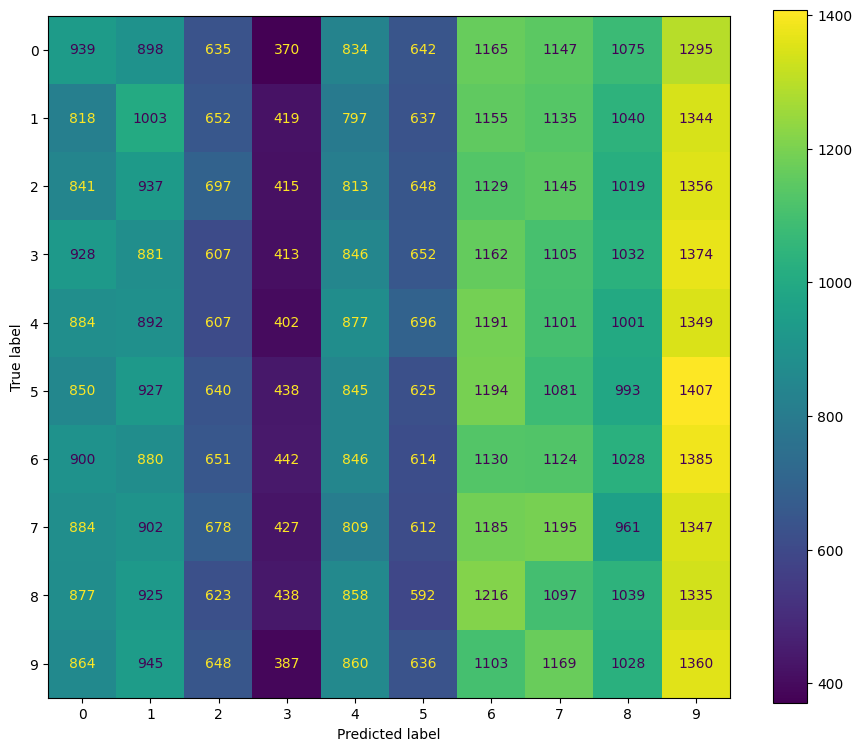

In [30]:
show_confusion_matrix_without_names(model2,test_ds,num_classes)

# Architektura trzeciego modelu

In [31]:
model3 = create_model3(num_classes)

In [32]:
model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [33]:
history = model3.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.7090 - categorical_accuracy: 0.3578 - auc: 0.8237 - precision: 0.6108 - recall: 0.1149 - f1_score: 0.3770 - val_loss: 1.5173 - val_categorical_accuracy: 0.4287 - val_auc: 0.8668 - val_precision: 0.6092 - val_recall: 0.2494 - val_f1_score: 0.2828
Epoch 2/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.4694 - categorical_accuracy: 0.4566 - auc: 0.8750 - precision: 0.6616 - recall: 0.2421 - f1_score: 0.3193 - val_loss: 1.4273 - val_categorical_accuracy: 0.4784 - val_auc: 0.8826 - val_precision: 0.6600 - val_recall: 0.3129 - val_f1_score: 0.3608
Epoch 3/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.3761 - categorical_accuracy: 0.4931 - auc: 0.8913 - precision: 0.6852 - recall: 0.2971 - f1_score: 0.3792 - val_loss: 1.2797 - val_categorical_accuracy: 0.5258 - val_auc: 0.9068 - val_precision: 0.6918 - val_recall: 0.3594 - val_f1_score: 0.4149
Epoch 4/20
5625/562

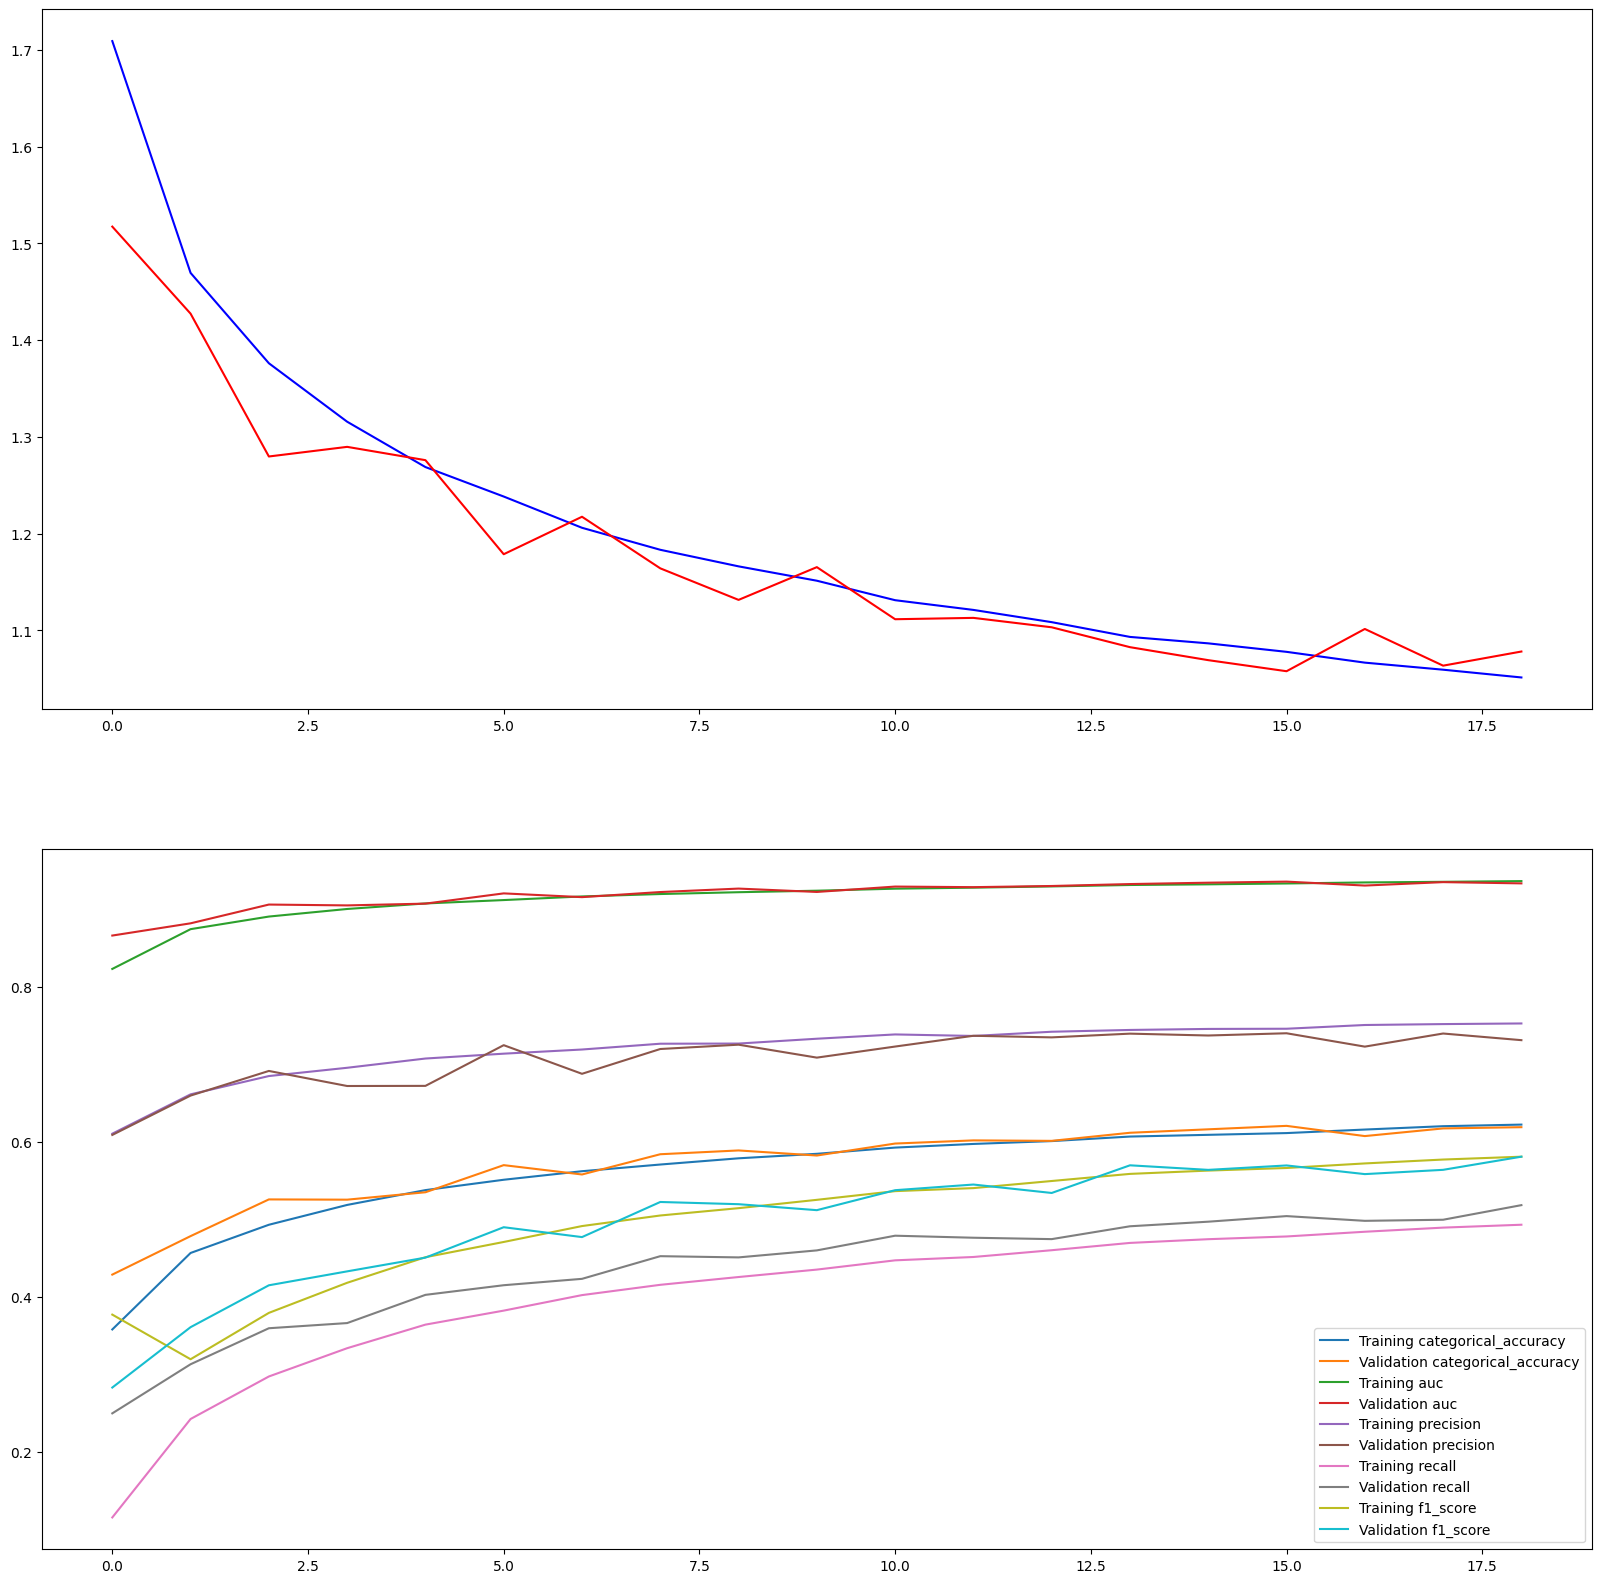

In [34]:
show_training_validation_loss_and_metrics(model3,metrics2)

In [35]:
model3.evaluate(test_it)

5625/5625 [==============================] - 45s 8ms/step - loss: 1.0854 - categorical_accuracy: 0.6163 - auc: 0.9332 - precision: 0.7312 - recall: 0.5165 - f1_score: 0.5807


[1.0853818655014038,
 0.6163111329078674,
 0.9332278966903687,
 0.7311636805534363,
 0.5164777636528015,
 0.580704391002655]

5625/5625 [==============================] - 23s 4ms/step


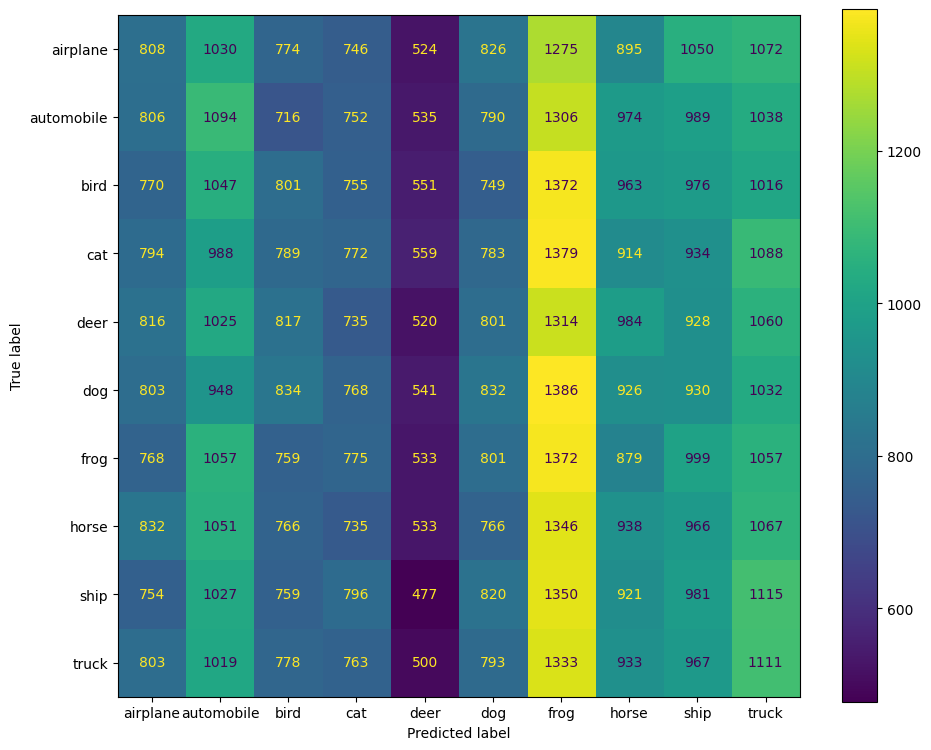

In [36]:
show_confusion_matrix(model3,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


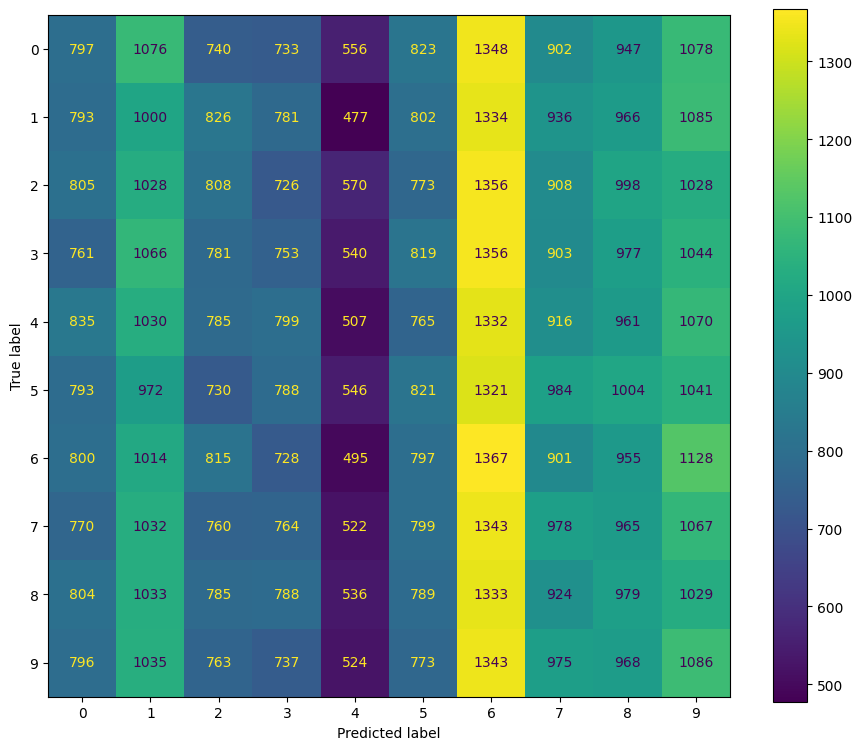

In [37]:
show_confusion_matrix_without_names(model3,test_ds,num_classes)

# Ziarno 1234

In [38]:
SEED = 1234
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [39]:
model11 = create_model1(num_classes)

In [40]:
model11.compile( 
    loss=loss_func,
    metrics=metrics
)

In [41]:
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [42]:
history = model11.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20


5625/5625 [==============================] - 123s 22ms/step - loss: 1.6297 - categorical_accuracy: 0.4108 - auc: 0.8456 - precision: 0.5865 - recall: 0.2157 - f1_score: 0.4533 - val_loss: 1.5260 - val_categorical_accuracy: 0.4607 - val_auc: 0.8707 - val_precision: 0.5823 - val_recall: 0.3233 - val_f1_score: 0.3758
Epoch 2/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.3366 - categorical_accuracy: 0.5163 - auc: 0.8978 - precision: 0.6870 - recall: 0.3390 - f1_score: 0.4285 - val_loss: 1.3181 - val_categorical_accuracy: 0.5273 - val_auc: 0.9018 - val_precision: 0.6690 - val_recall: 0.3903 - val_f1_score: 0.4574
Epoch 3/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.2414 - categorical_accuracy: 0.5522 - auc: 0.9121 - precision: 0.7108 - recall: 0.3904 - f1_score: 0.4807 - val_loss: 1.3015 - val_categorical_accuracy: 0.5178 - val_auc: 0.9043 - val_precision: 0.6718 - val_recall: 0.3729 - val_f1_score: 0.4389
Epoch 4/20
5625/5625 [========

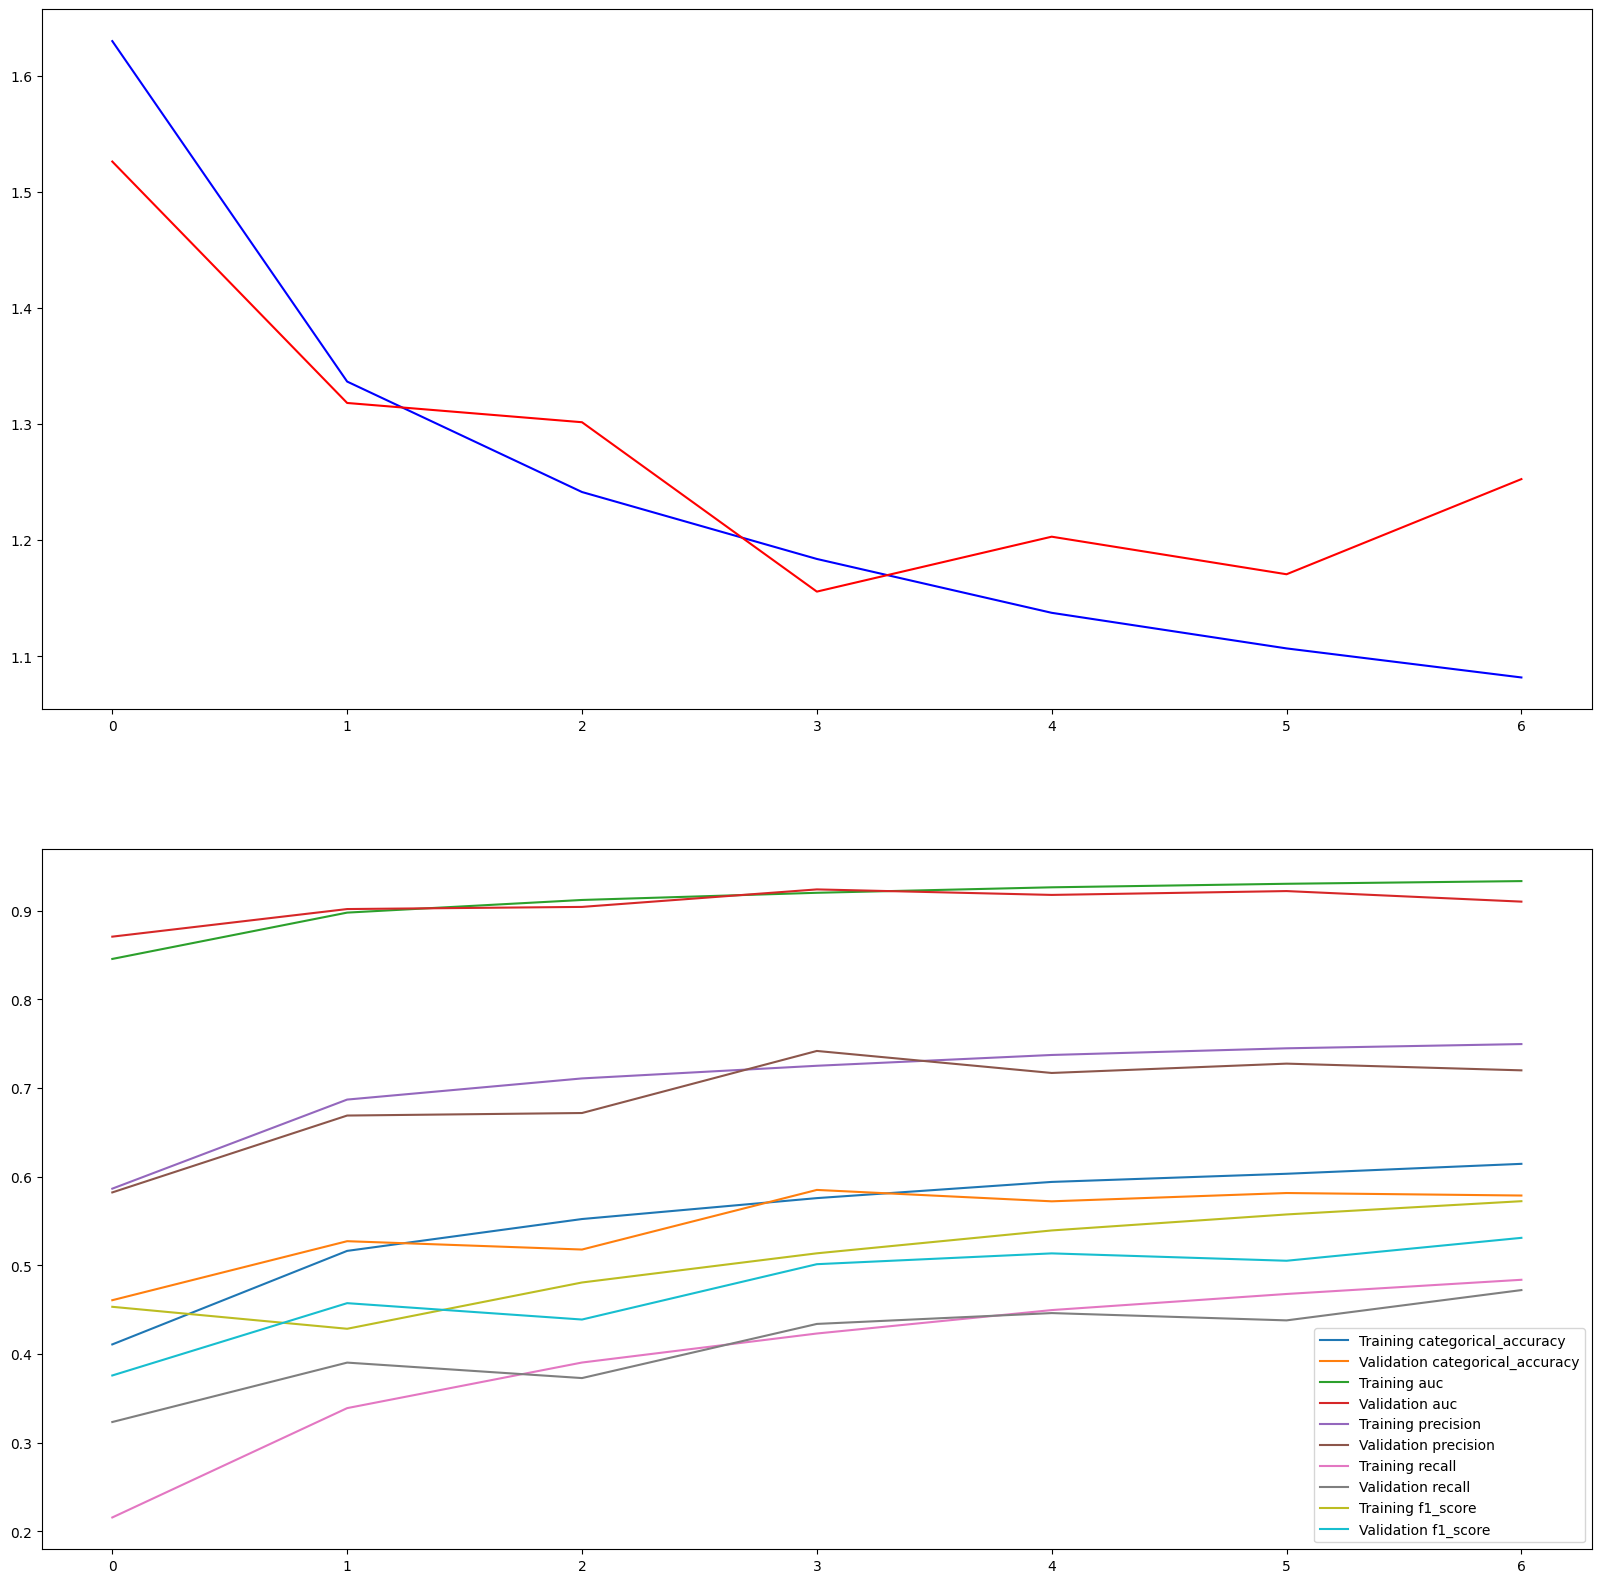

In [43]:
show_training_validation_loss_and_metrics(model11,metrics2)

In [44]:
model11.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.2699 - categorical_accuracy: 0.5754 - auc: 0.9080 - precision: 0.7169 - recall: 0.4698 - f1_score: 0.5272


[1.2699062824249268,
 0.5753999948501587,
 0.9079883098602295,
 0.7169356942176819,
 0.4697999954223633,
 0.5272353887557983]

5625/5625 [==============================] - 21s 4ms/step


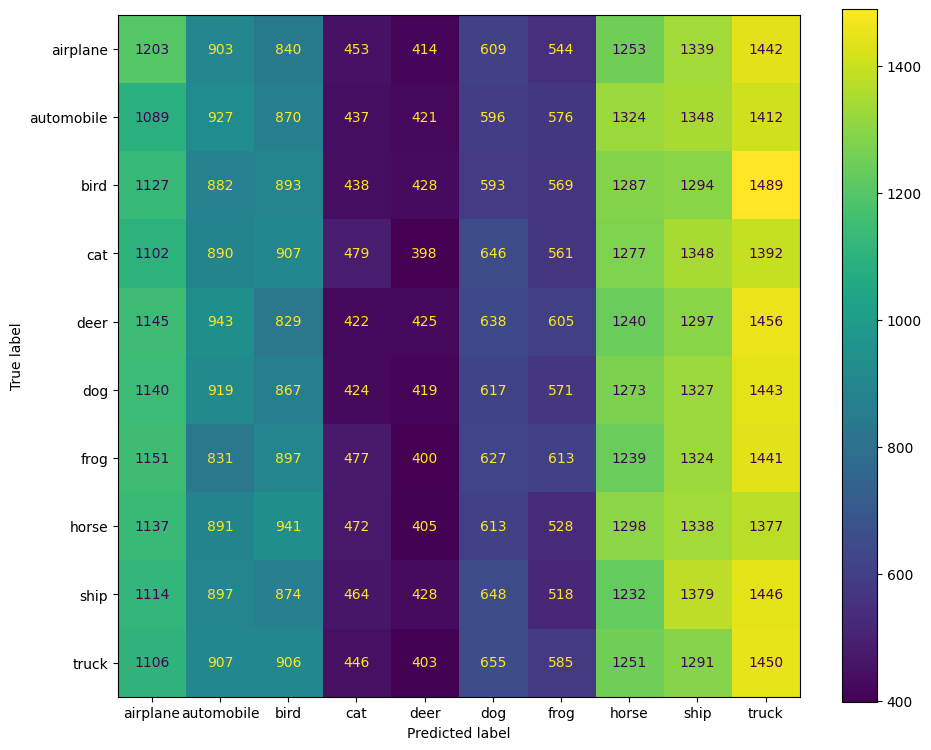

In [45]:
show_confusion_matrix(model11,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 3ms/step


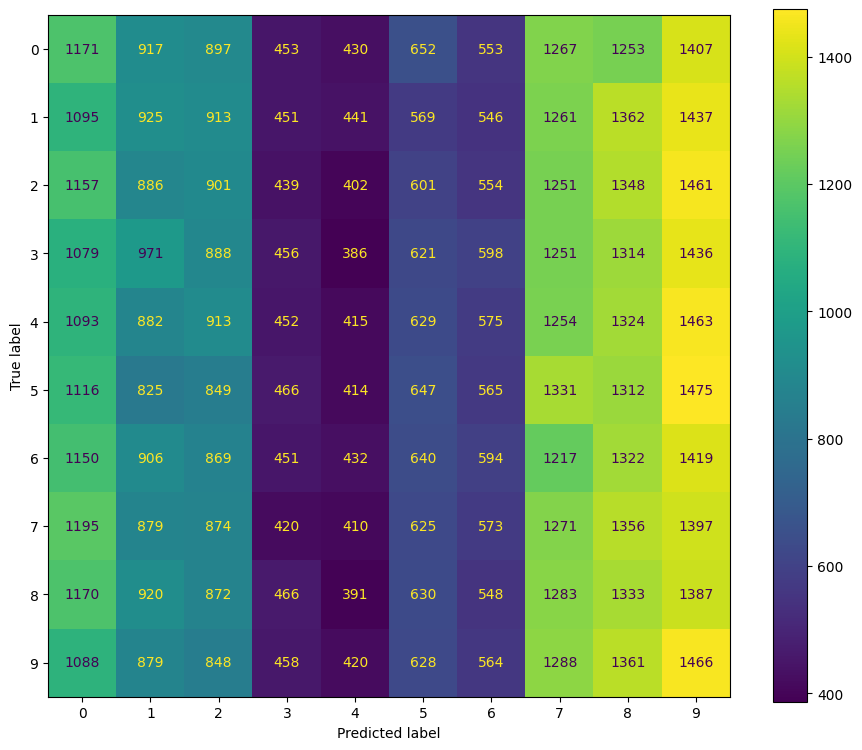

In [46]:
show_confusion_matrix_without_names(model11,test_ds,num_classes)

# Architektura drugiego modelu

In [47]:
model21 = create_model2(num_classes)

In [48]:
model21.compile( 
    loss=loss_func,
    metrics=metrics
)

In [49]:
model21.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_9 (Laye  (None, 32, 32, 75)       150       
 rNormalization)                                                 
                                                                 
 average_pooling2d_3 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_10 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [50]:
history = model21.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.7867 - categorical_accuracy: 0.3472 - auc: 0.8063 - precision: 0.5801 - recall: 0.1148 - f1_score: 0.3816 - val_loss: 1.5080 - val_categorical_accuracy: 0.4422 - val_auc: 0.8681 - val_precision: 0.6547 - val_recall: 0.2018 - val_f1_score: 0.2562
Epoch 2/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.4973 - categorical_accuracy: 0.4521 - auc: 0.8698 - precision: 0.6584 - recall: 0.2330 - f1_score: 0.3147 - val_loss: 1.3738 - val_categorical_accuracy: 0.5012 - val_auc: 0.8916 - val_precision: 0.6814 - val_recall: 0.3225 - val_f1_score: 0.3868
Epoch 3/20
5625/5625 [==============================] - 121s 22ms/step - loss: 1.3971 - categorical_accuracy: 0.4918 - auc: 0.8877 - precision: 0.6845 - recall: 0.2910 - f1_score: 0.3783 - val_loss: 1.3026 - val_categorical_accuracy: 0.5264 - val_auc: 0.9029 - val_precision: 0.7077 - val_recall: 0.3418 - val_f1_score: 0.4087
Epoch 4/20
5625/562

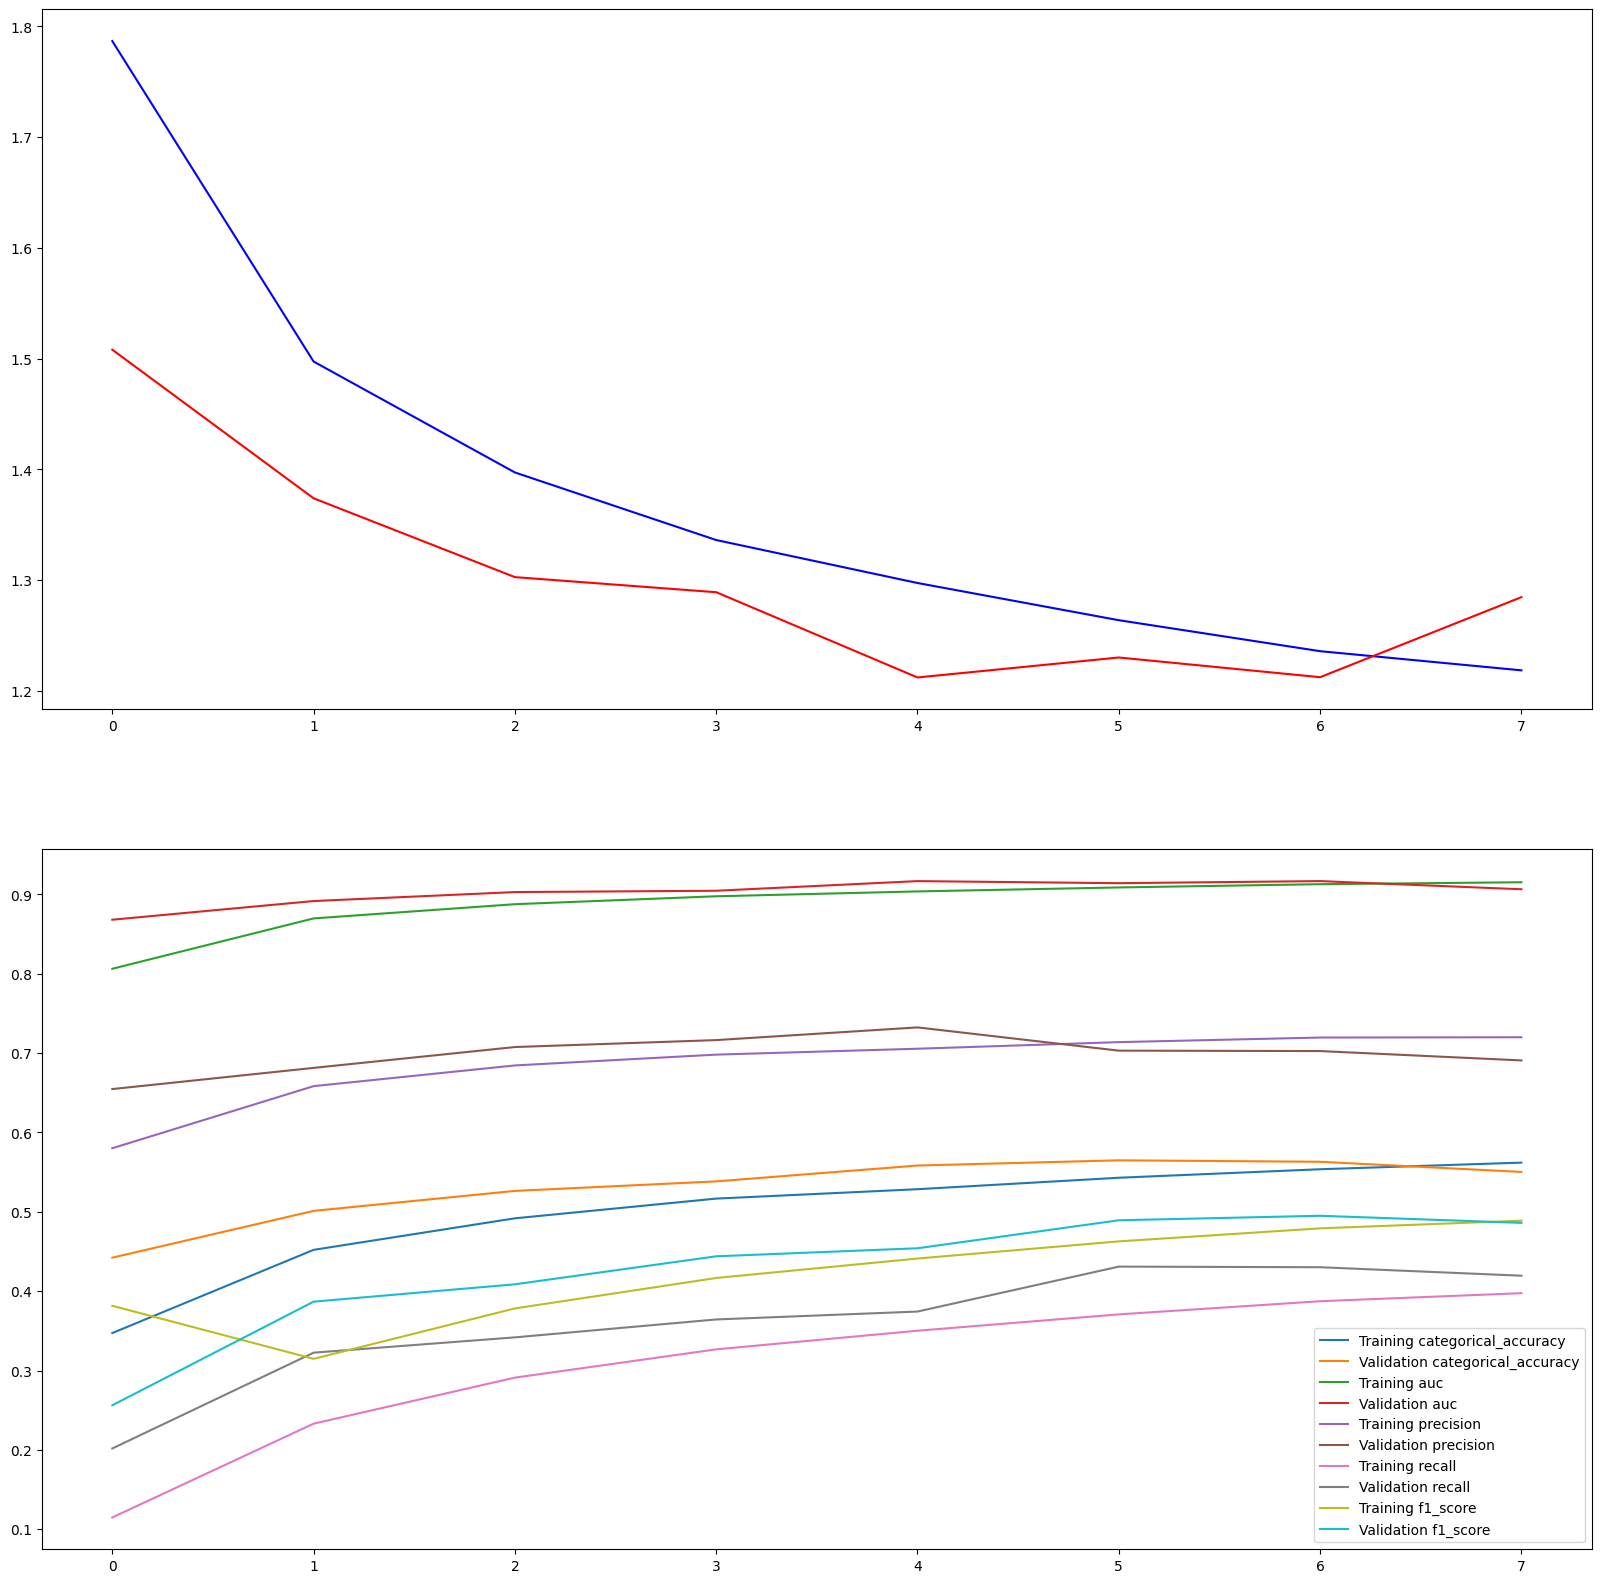

In [51]:
show_training_validation_loss_and_metrics(model21,metrics2)

In [52]:
model21.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.2969 - categorical_accuracy: 0.5473 - auc: 0.9047 - precision: 0.6886 - recall: 0.4190 - f1_score: 0.4846


[1.2968908548355103,
 0.547344446182251,
 0.9047156572341919,
 0.6885808706283569,
 0.41895556449890137,
 0.4845627546310425]

5625/5625 [==============================] - 21s 4ms/step


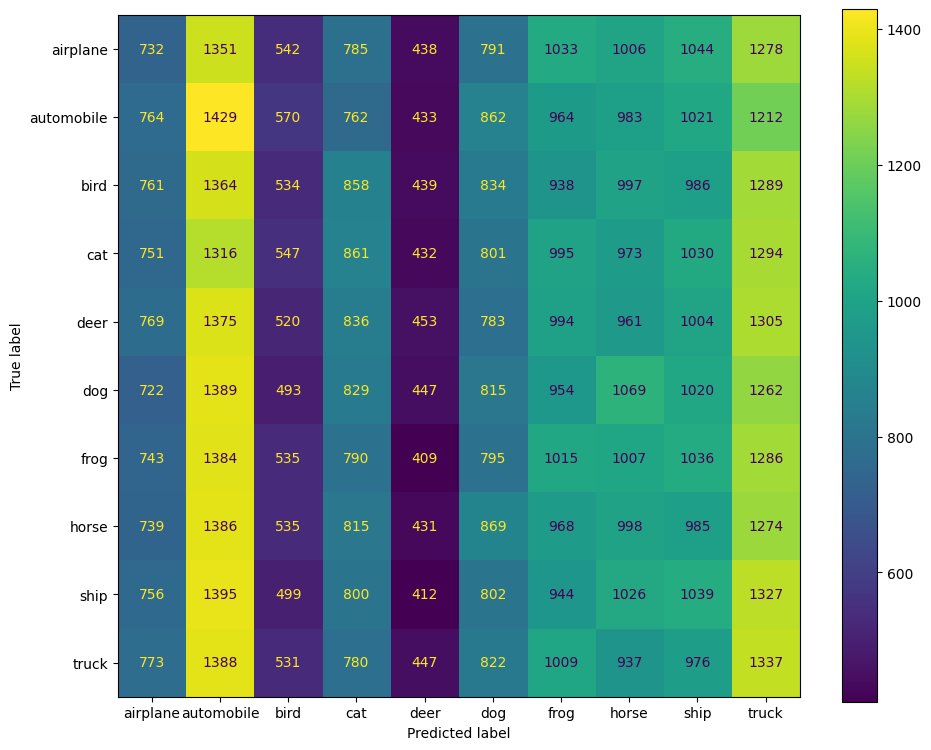

In [53]:
show_confusion_matrix(model21,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


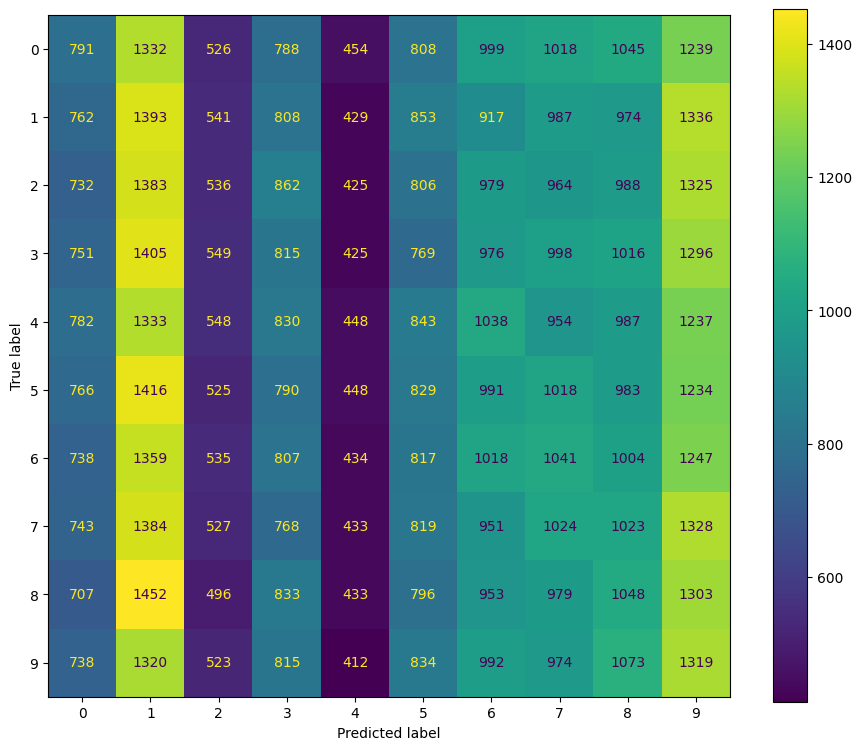

In [54]:
show_confusion_matrix_without_names(model21,test_ds,num_classes)

# Architektura trzeciego modelu

In [55]:
model31 = create_model3(num_classes)

model31.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [56]:
history = model31.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.7273 - categorical_accuracy: 0.3497 - auc: 0.8182 - precision: 0.6118 - recall: 0.1093 - f1_score: 0.3517 - val_loss: 1.5092 - val_categorical_accuracy: 0.4425 - val_auc: 0.8677 - val_precision: 0.6426 - val_recall: 0.2482 - val_f1_score: 0.3038
Epoch 2/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.4742 - categorical_accuracy: 0.4556 - auc: 0.8742 - precision: 0.6616 - recall: 0.2381 - f1_score: 0.3127 - val_loss: 1.4615 - val_categorical_accuracy: 0.4725 - val_auc: 0.8771 - val_precision: 0.6439 - val_recall: 0.3188 - val_f1_score: 0.3640
Epoch 3/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.3712 - categorical_accuracy: 0.4962 - auc: 0.8922 - precision: 0.6885 - recall: 0.2997 - f1_score: 0.3782 - val_loss: 1.3965 - val_categorical_accuracy: 0.4938 - val_auc: 0.8884 - val_precision: 0.6615 - val_recall: 0.3406 - val_f1_score: 0.3875
Epoch 4/20
5625/562

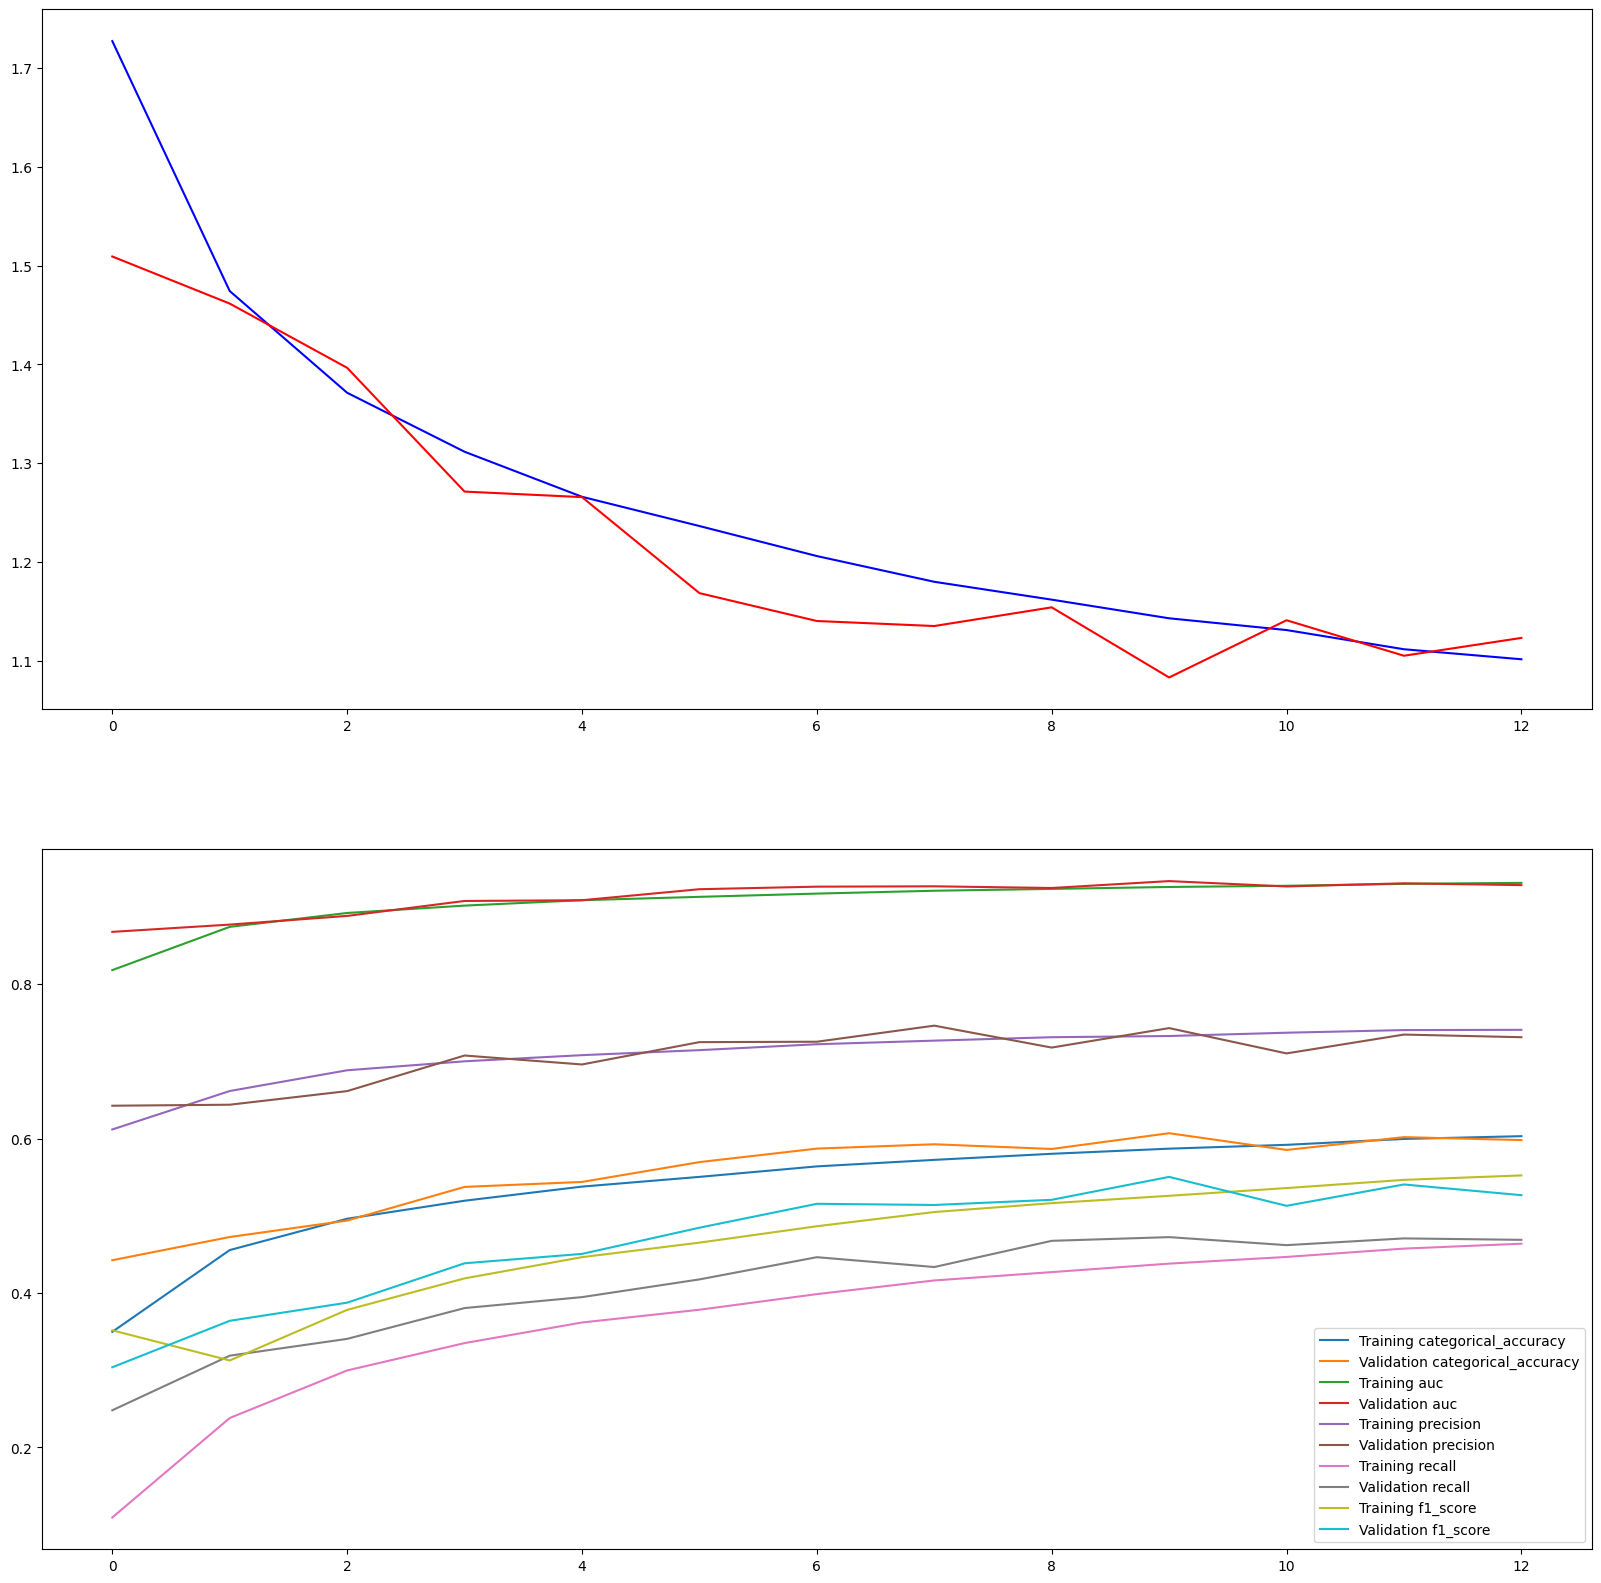

In [57]:
show_training_validation_loss_and_metrics(model31,metrics2)

In [58]:
model31.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.1288 - categorical_accuracy: 0.5973 - auc: 0.9275 - precision: 0.7340 - recall: 0.4686 - f1_score: 0.5278


[1.1288098096847534,
 0.5972889065742493,
 0.9274657368659973,
 0.733977198600769,
 0.4686444401741028,
 0.5278483629226685]

5625/5625 [==============================] - 22s 4ms/step


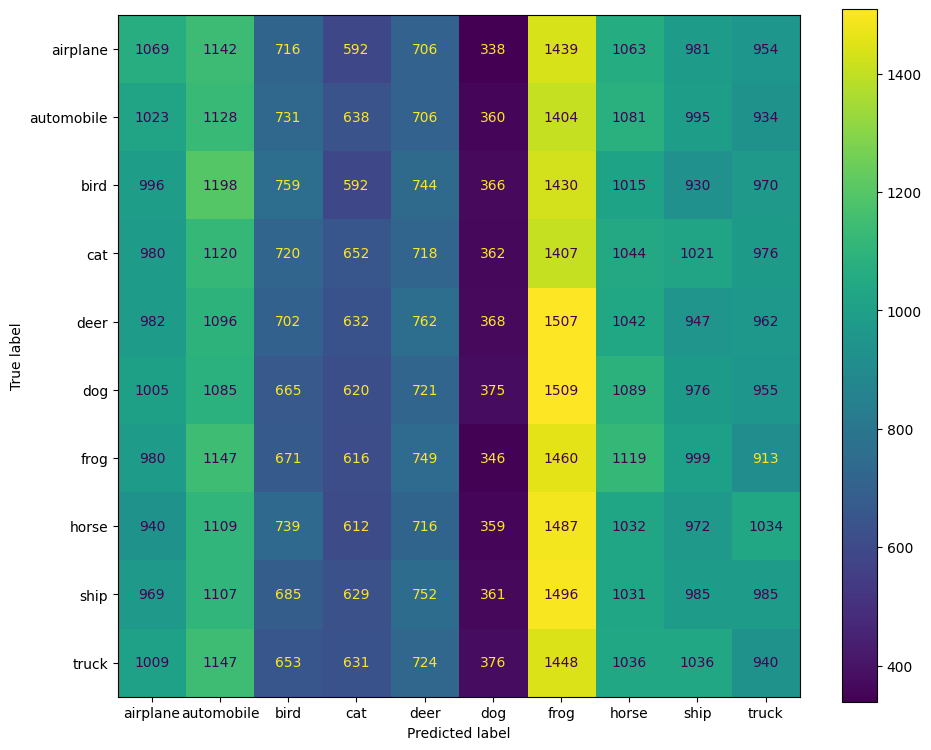

In [59]:
show_confusion_matrix(model31,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


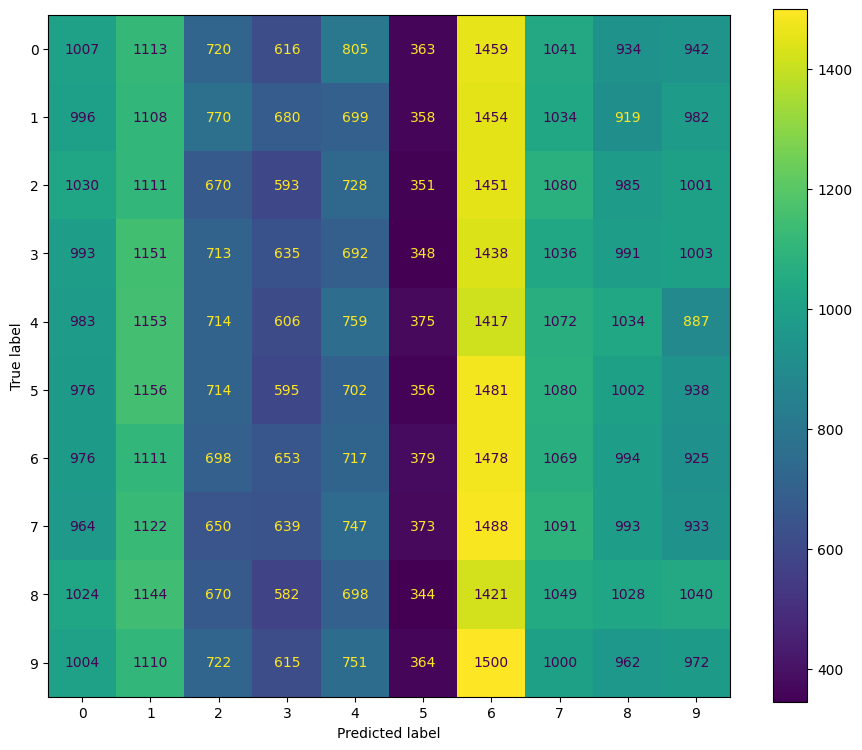

In [60]:
show_confusion_matrix_without_names(model31,test_ds,num_classes)

# Ziarno 2137

In [61]:
SEED = 2137

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [62]:
model12 = create_model1(num_classes)

In [63]:
model12.compile( 
    loss=loss_func,
    metrics=metrics
)

In [64]:
model12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [65]:
history = model12.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 121s 21ms/step - loss: 1.6211 - categorical_accuracy: 0.4145 - auc: 0.8473 - precision: 0.5881 - recall: 0.2214 - f1_score: 0.4250 - val_loss: 1.5643 - val_categorical_accuracy: 0.4361 - val_auc: 0.8623 - val_precision: 0.5880 - val_recall: 0.3031 - val_f1_score: 0.3316
Epoch 2/20
5625/5625 [==============================] - 118s 21ms/step - loss: 1.3287 - categorical_accuracy: 0.5188 - auc: 0.8989 - precision: 0.6907 - recall: 0.3449 - f1_score: 0.4348 - val_loss: 1.3637 - val_categorical_accuracy: 0.5250 - val_auc: 0.8922 - val_precision: 0.6990 - val_recall: 0.3724 - val_f1_score: 0.4316
Epoch 3/20
5625/5625 [==============================] - 118s 21ms/step - loss: 1.2330 - categorical_accuracy: 0.5588 - auc: 0.9133 - precision: 0.7171 - recall: 0.3993 - f1_score: 0.4908 - val_loss: 1.5437 - val_categorical_accuracy: 0.4852 - val_auc: 0.8719 - val_precision: 0.6109 - val_recall: 0.3924 - val_f1_score: 0.4189
Epoch 4/20
5625/562

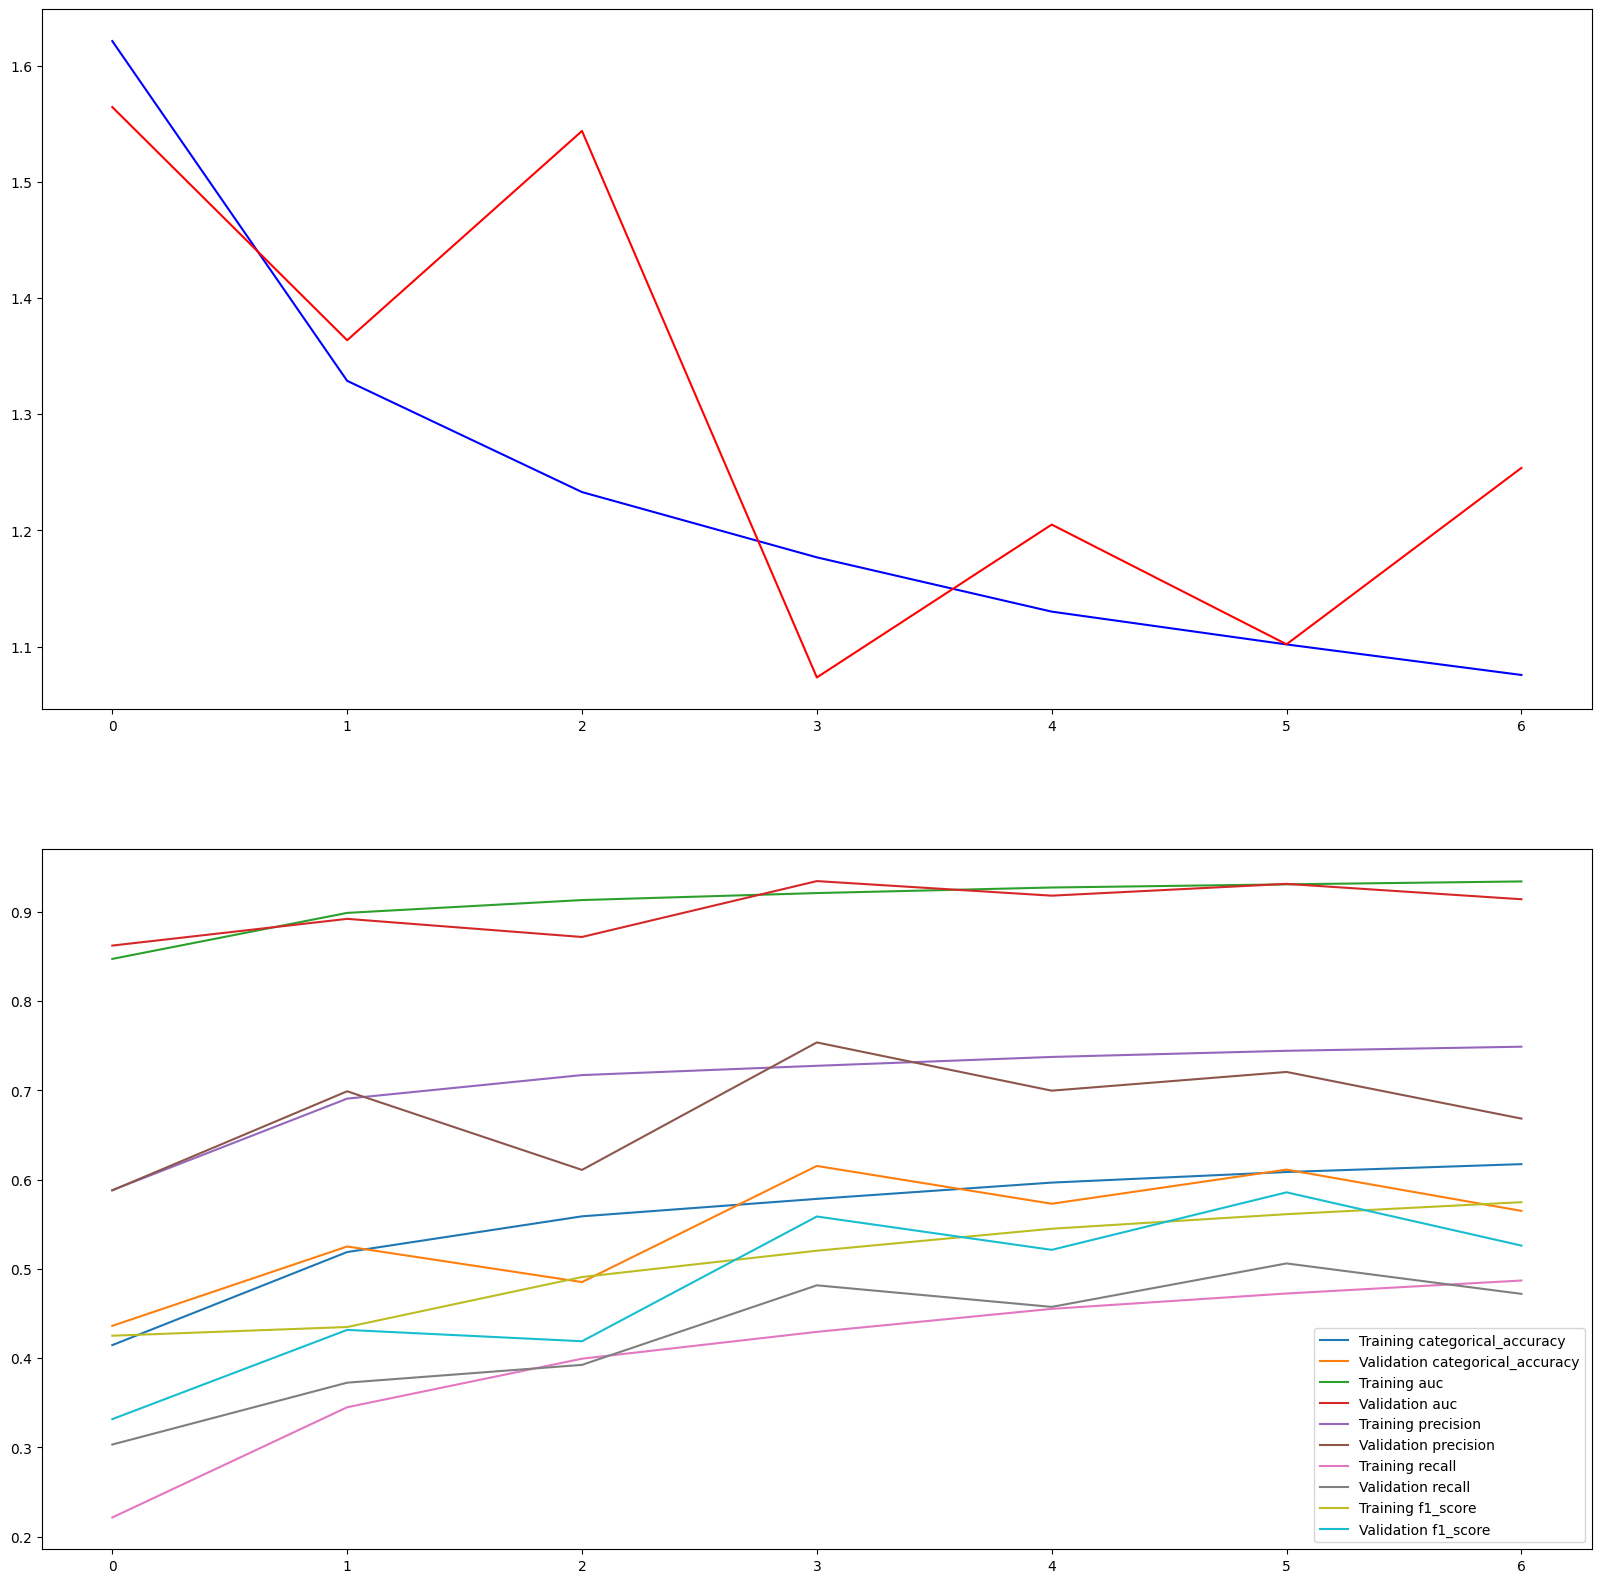

In [66]:
show_training_validation_loss_and_metrics(model12,metrics2)

In [67]:
model12.evaluate(test_it)

5625/5625 [==============================] - 43s 8ms/step - loss: 1.2643 - categorical_accuracy: 0.5622 - auc: 0.9129 - precision: 0.6650 - recall: 0.4694 - f1_score: 0.5238


[1.2642583847045898,
 0.5621777772903442,
 0.9128847718238831,
 0.665040135383606,
 0.4694444537162781,
 0.5237575173377991]

5625/5625 [==============================] - 20s 4ms/step


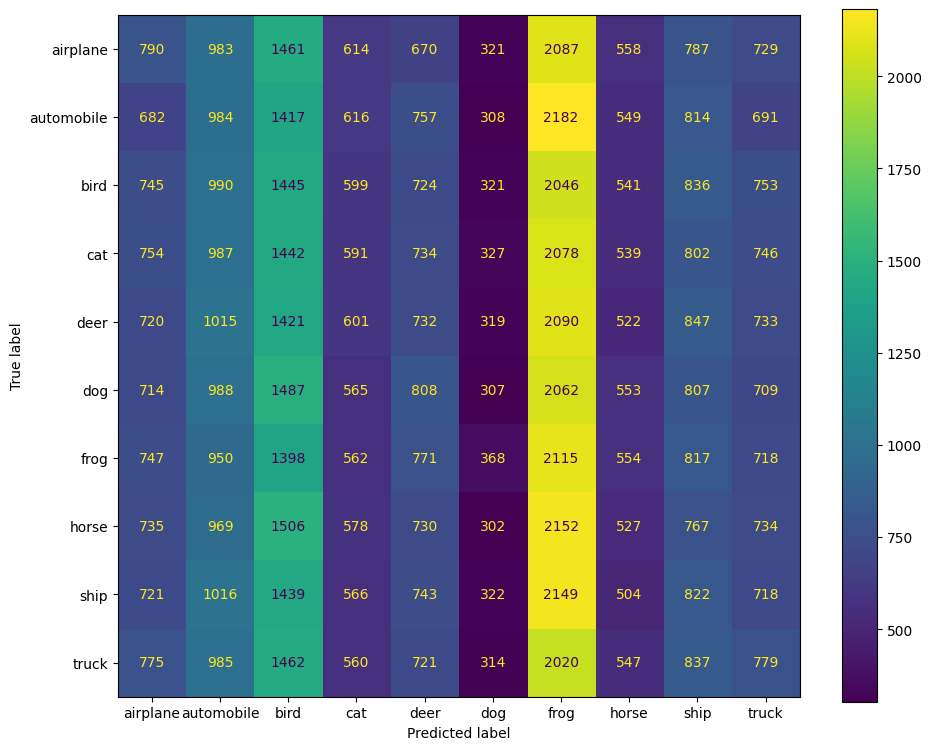

In [68]:
show_confusion_matrix(model12,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


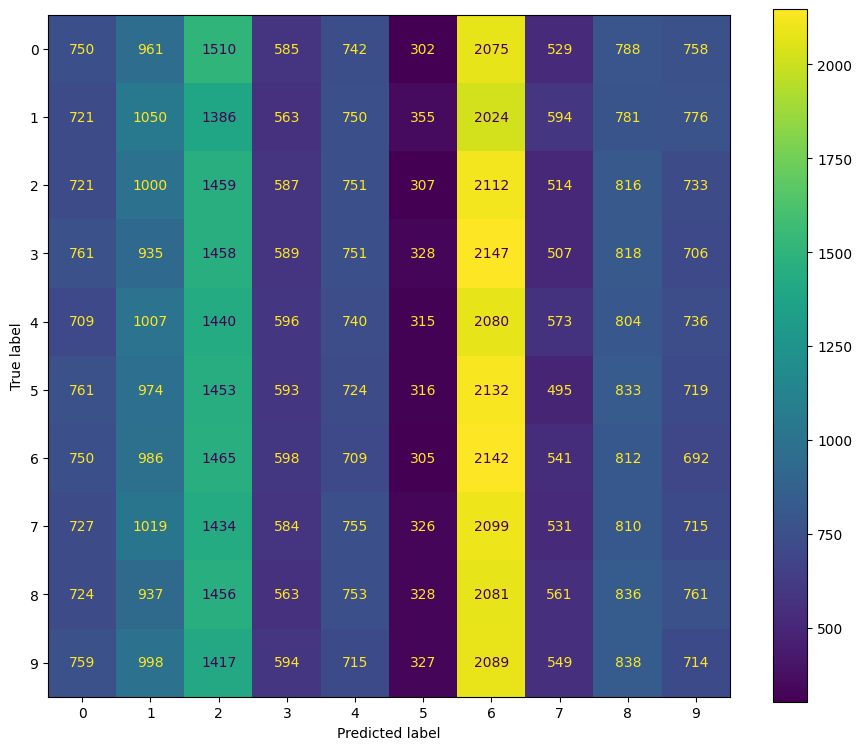

In [69]:
show_confusion_matrix_without_names(model12,test_ds,num_classes)

# Architektura drugiego modelu

In [70]:
model22 = create_model2(num_classes)

In [71]:
model22.compile( 
    loss=loss_func,
    metrics=metrics
)

In [72]:
model22.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_18 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_19 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [73]:
history = model22.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.7857 - categorical_accuracy: 0.3528 - auc: 0.8074 - precision: 0.5809 - recall: 0.1185 - f1_score: 0.3829 - val_loss: 1.5024 - val_categorical_accuracy: 0.4445 - val_auc: 0.8687 - val_precision: 0.6723 - val_recall: 0.2176 - val_f1_score: 0.2855
Epoch 2/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.4923 - categorical_accuracy: 0.4557 - auc: 0.8706 - precision: 0.6606 - recall: 0.2391 - f1_score: 0.3217 - val_loss: 1.3574 - val_categorical_accuracy: 0.5074 - val_auc: 0.8947 - val_precision: 0.7058 - val_recall: 0.2875 - val_f1_score: 0.3628
Epoch 3/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.4011 - categorical_accuracy: 0.4907 - auc: 0.8869 - precision: 0.6801 - recall: 0.2904 - f1_score: 0.3770 - val_loss: 1.3389 - val_categorical_accuracy: 0.5076 - val_auc: 0.8974 - val_precision: 0.6928 - val_recall: 0.3162 - val_f1_score: 0.3880
Epoch 4/20
5625/562

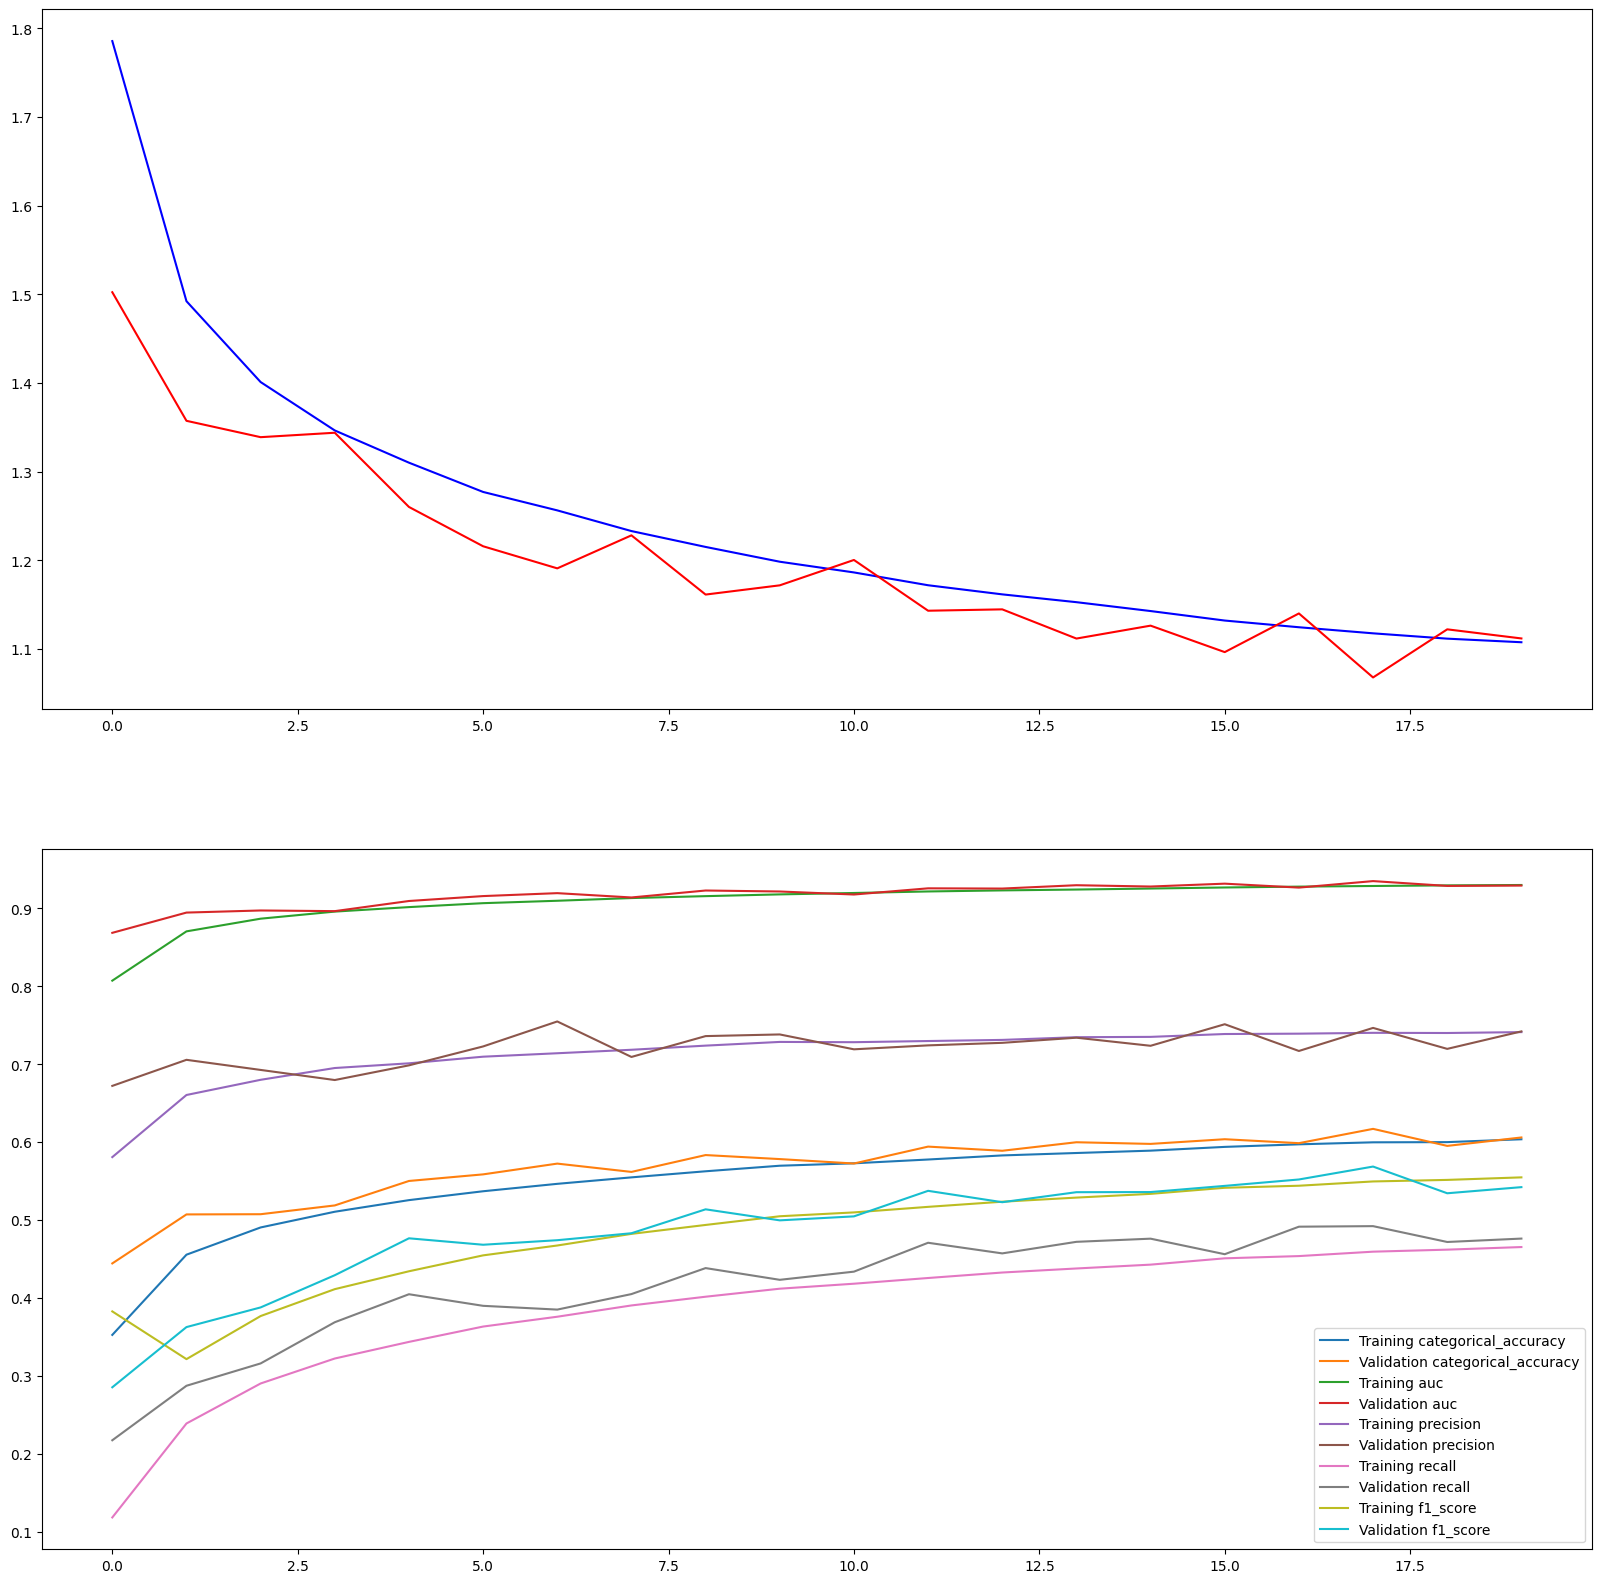

In [74]:
show_training_validation_loss_and_metrics(model22,metrics2)

In [75]:
model22.evaluate(test_it)

5625/5625 [==============================] - 43s 8ms/step - loss: 1.1280 - categorical_accuracy: 0.6017 - auc: 0.9273 - precision: 0.7381 - recall: 0.4723 - f1_score: 0.5381


[1.1279642581939697,
 0.601722240447998,
 0.9273378849029541,
 0.7380712628364563,
 0.4722999930381775,
 0.5380672812461853]

5625/5625 [==============================] - 21s 4ms/step


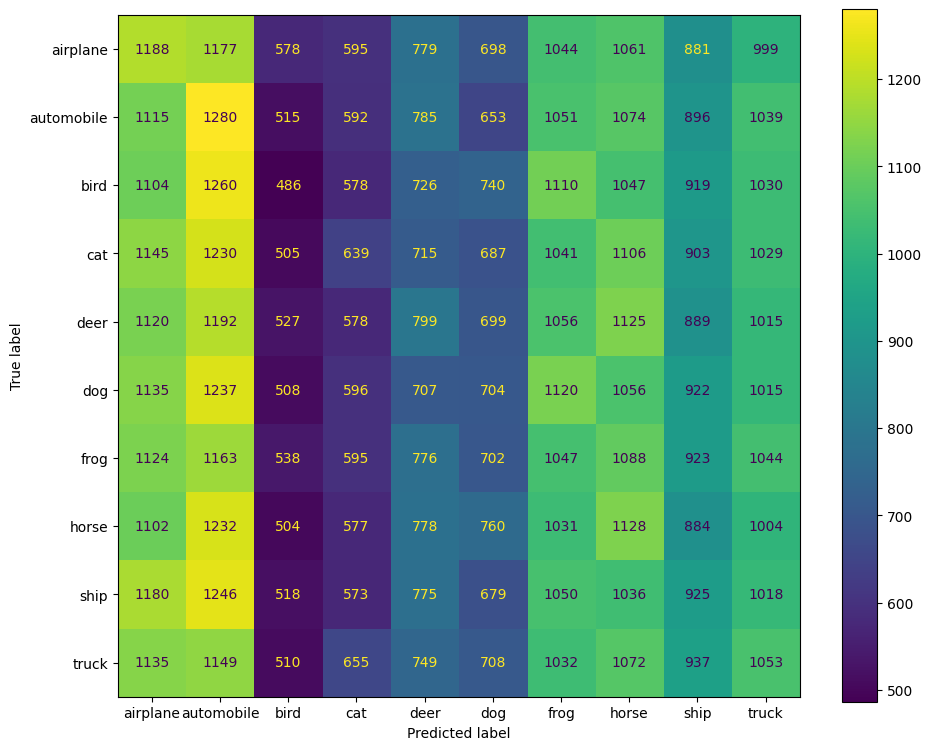

In [76]:
show_confusion_matrix(model22,test_ds,num_classes,class_names)

5625/5625 [==============================] - 21s 4ms/step


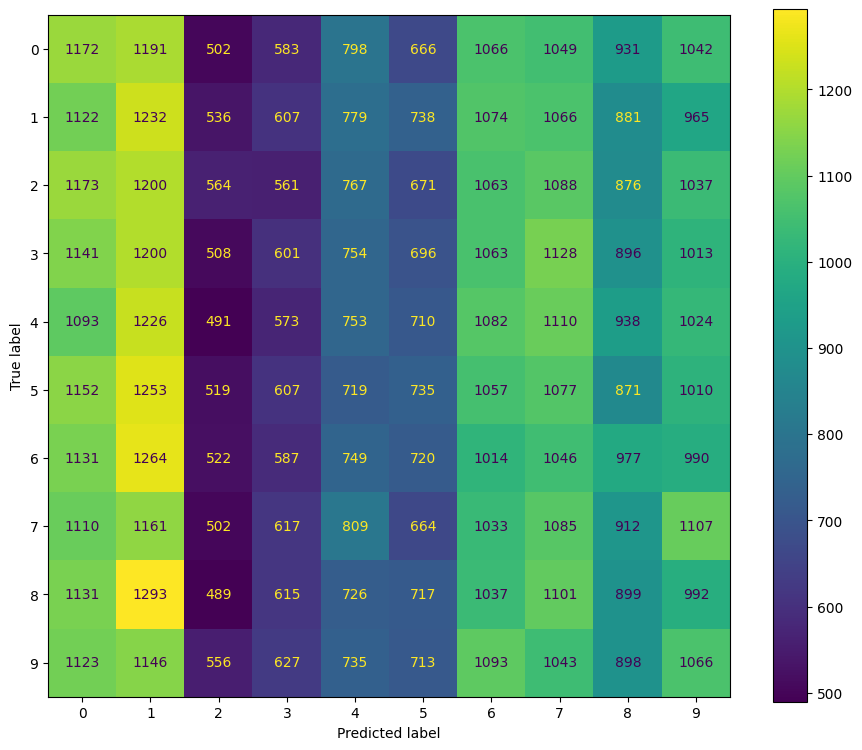

In [77]:
show_confusion_matrix_without_names(model22,test_ds,num_classes)

# Architektura trzeciego modelu

In [78]:
model32 = create_model3(num_classes)

model32.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [79]:
model32.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 layer_normalization_22 (Lay  (None, 32, 32, 256)      512       
 erNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 layer_normalization_23 (Lay  (None, 16, 16, 128)      256       
 erNormalization)                                                
                                                      

In [80]:
history = model32.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.7270 - categorical_accuracy: 0.3468 - auc: 0.8191 - precision: 0.6000 - recall: 0.1036 - f1_score: 0.3813 - val_loss: 1.6062 - val_categorical_accuracy: 0.4129 - val_auc: 0.8493 - val_precision: 0.5974 - val_recall: 0.2312 - val_f1_score: 0.2816
Epoch 2/20
5625/5625 [==============================] - 117s 21ms/step - loss: 1.4726 - categorical_accuracy: 0.4550 - auc: 0.8746 - precision: 0.6589 - recall: 0.2370 - f1_score: 0.3151 - val_loss: 1.3774 - val_categorical_accuracy: 0.4938 - val_auc: 0.8912 - val_precision: 0.6741 - val_recall: 0.3017 - val_f1_score: 0.3693
Epoch 3/20
5625/5625 [==============================] - 117s 21ms/step - loss: 1.3713 - categorical_accuracy: 0.4955 - auc: 0.8921 - precision: 0.6842 - recall: 0.3008 - f1_score: 0.3831 - val_loss: 1.2724 - val_categorical_accuracy: 0.5323 - val_auc: 0.9078 - val_precision: 0.6963 - val_recall: 0.3686 - val_f1_score: 0.4300
Epoch 4/20
5625/562

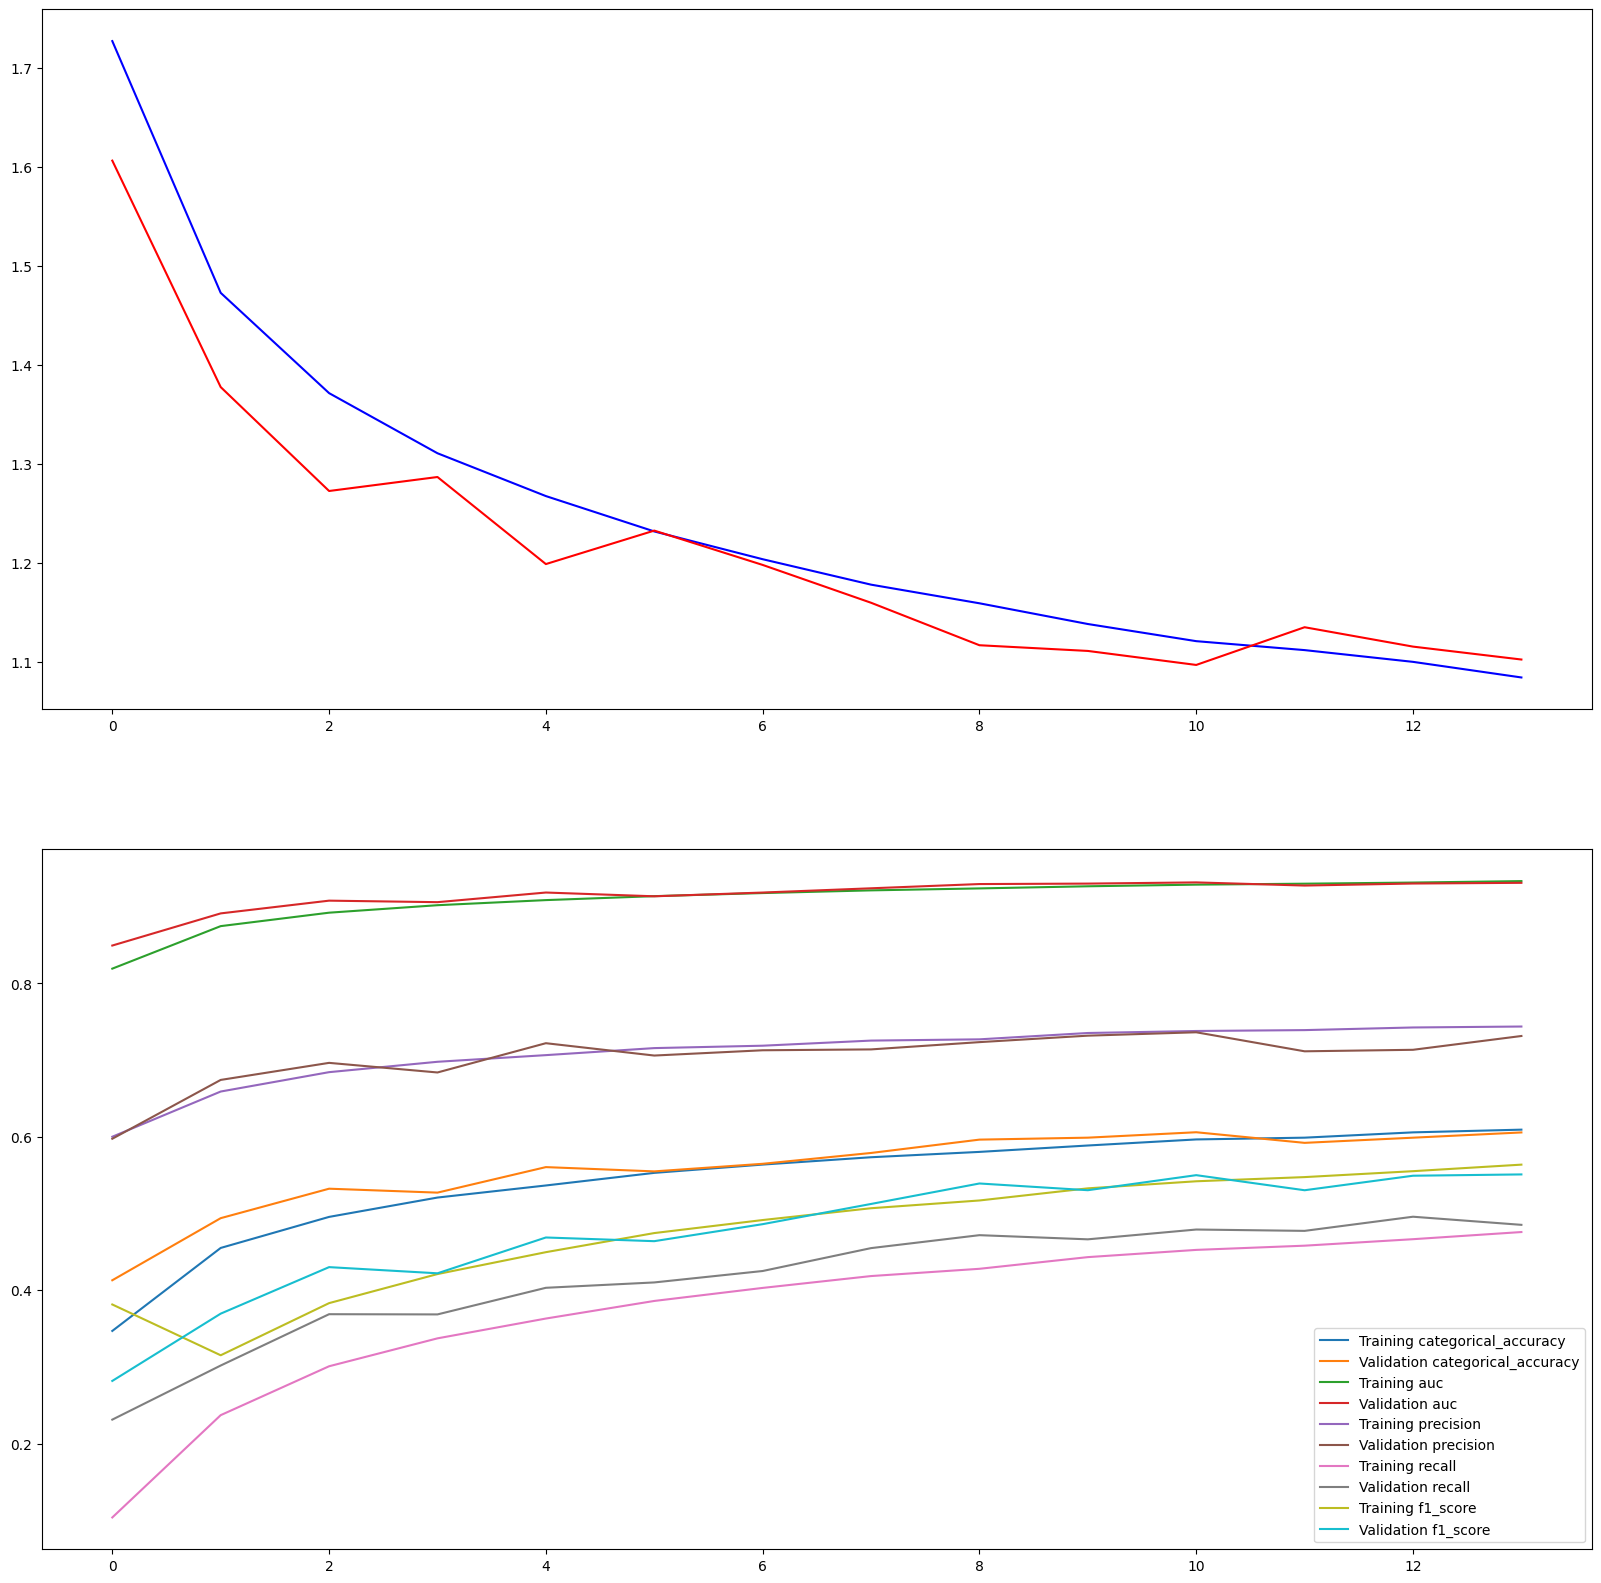

In [81]:
show_training_validation_loss_and_metrics(model32,metrics2)

In [82]:
model32.evaluate(test_it)

5625/5625 [==============================] - 45s 8ms/step - loss: 1.1090 - categorical_accuracy: 0.6035 - auc: 0.9301 - precision: 0.7291 - recall: 0.4842 - f1_score: 0.5499


[1.1090412139892578,
 0.6035444736480713,
 0.930130124092102,
 0.7290781140327454,
 0.48418888449668884,
 0.5499286651611328]

5625/5625 [==============================] - 22s 4ms/step


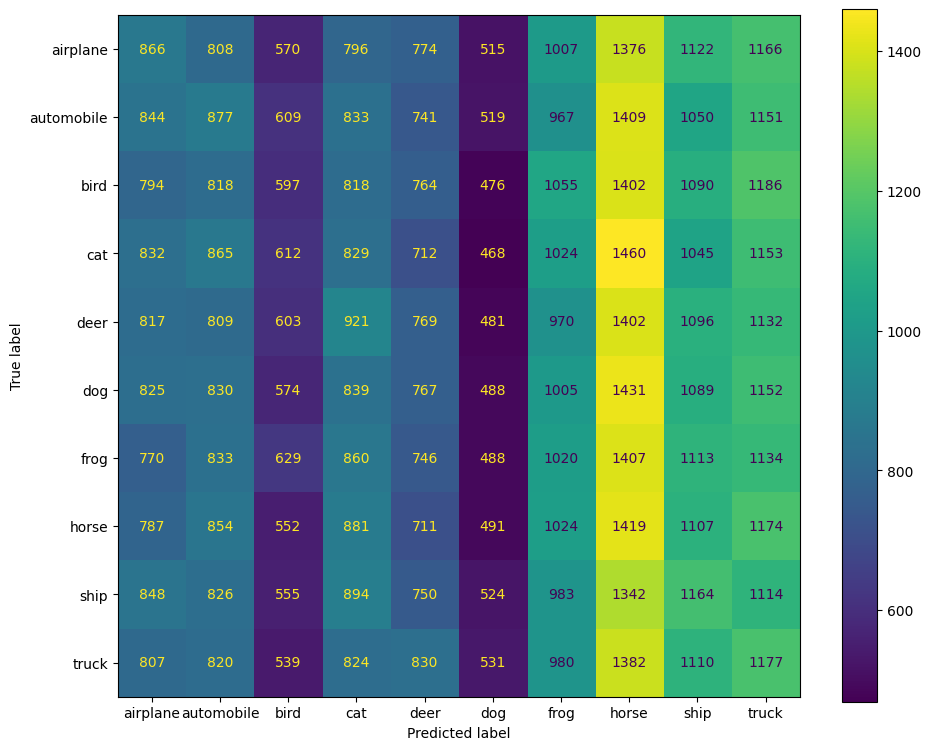

In [83]:
show_confusion_matrix(model32,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


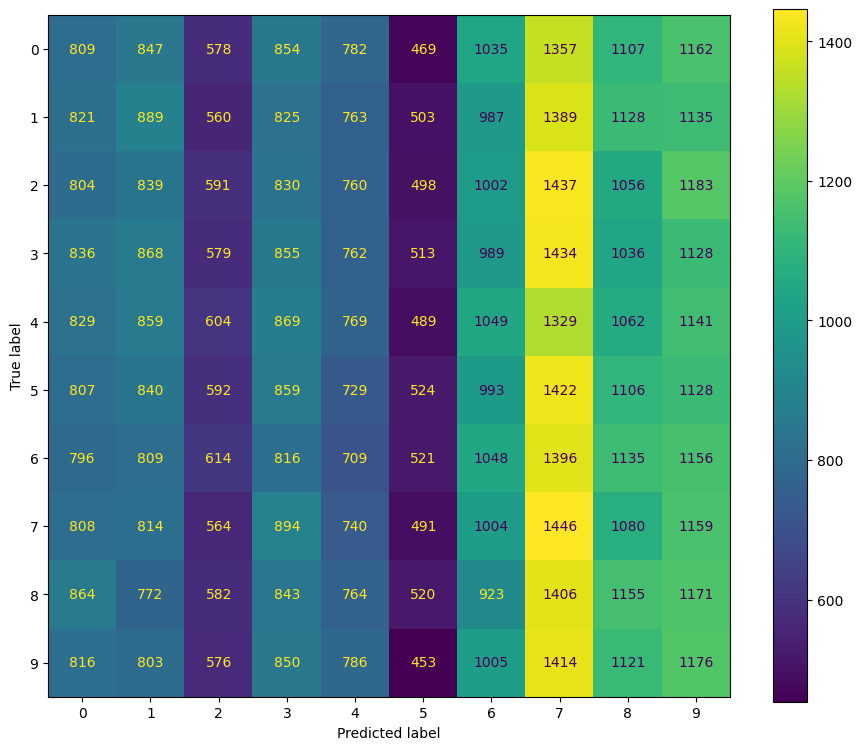

In [84]:
show_confusion_matrix_without_names(model32,test_ds,num_classes)

# Ziarno 7654

In [85]:
SEED = 7654

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [86]:
model13 = create_model1(num_classes)

In [87]:
model13.compile( 
    loss=loss_func,
    metrics=metrics
)

In [88]:

model13.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                      

In [89]:
history = model13.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 121s 21ms/step - loss: 1.6365 - categorical_accuracy: 0.4097 - auc: 0.8441 - precision: 0.5843 - recall: 0.2157 - f1_score: 0.4347 - val_loss: 1.4006 - val_categorical_accuracy: 0.4968 - val_auc: 0.8887 - val_precision: 0.6452 - val_recall: 0.3465 - val_f1_score: 0.3864
Epoch 2/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.3342 - categorical_accuracy: 0.5151 - auc: 0.8982 - precision: 0.6874 - recall: 0.3406 - f1_score: 0.4293 - val_loss: 1.2246 - val_categorical_accuracy: 0.5610 - val_auc: 0.9144 - val_precision: 0.7275 - val_recall: 0.3978 - val_f1_score: 0.4770
Epoch 3/20
5625/5625 [==============================] - 118s 21ms/step - loss: 1.2392 - categorical_accuracy: 0.5539 - auc: 0.9124 - precision: 0.7124 - recall: 0.3940 - f1_score: 0.4845 - val_loss: 1.4822 - val_categorical_accuracy: 0.5068 - val_auc: 0.8778 - val_precision: 0.6521 - val_recall: 0.3889 - val_f1_score: 0.4411
Epoch 4/20
5625/562

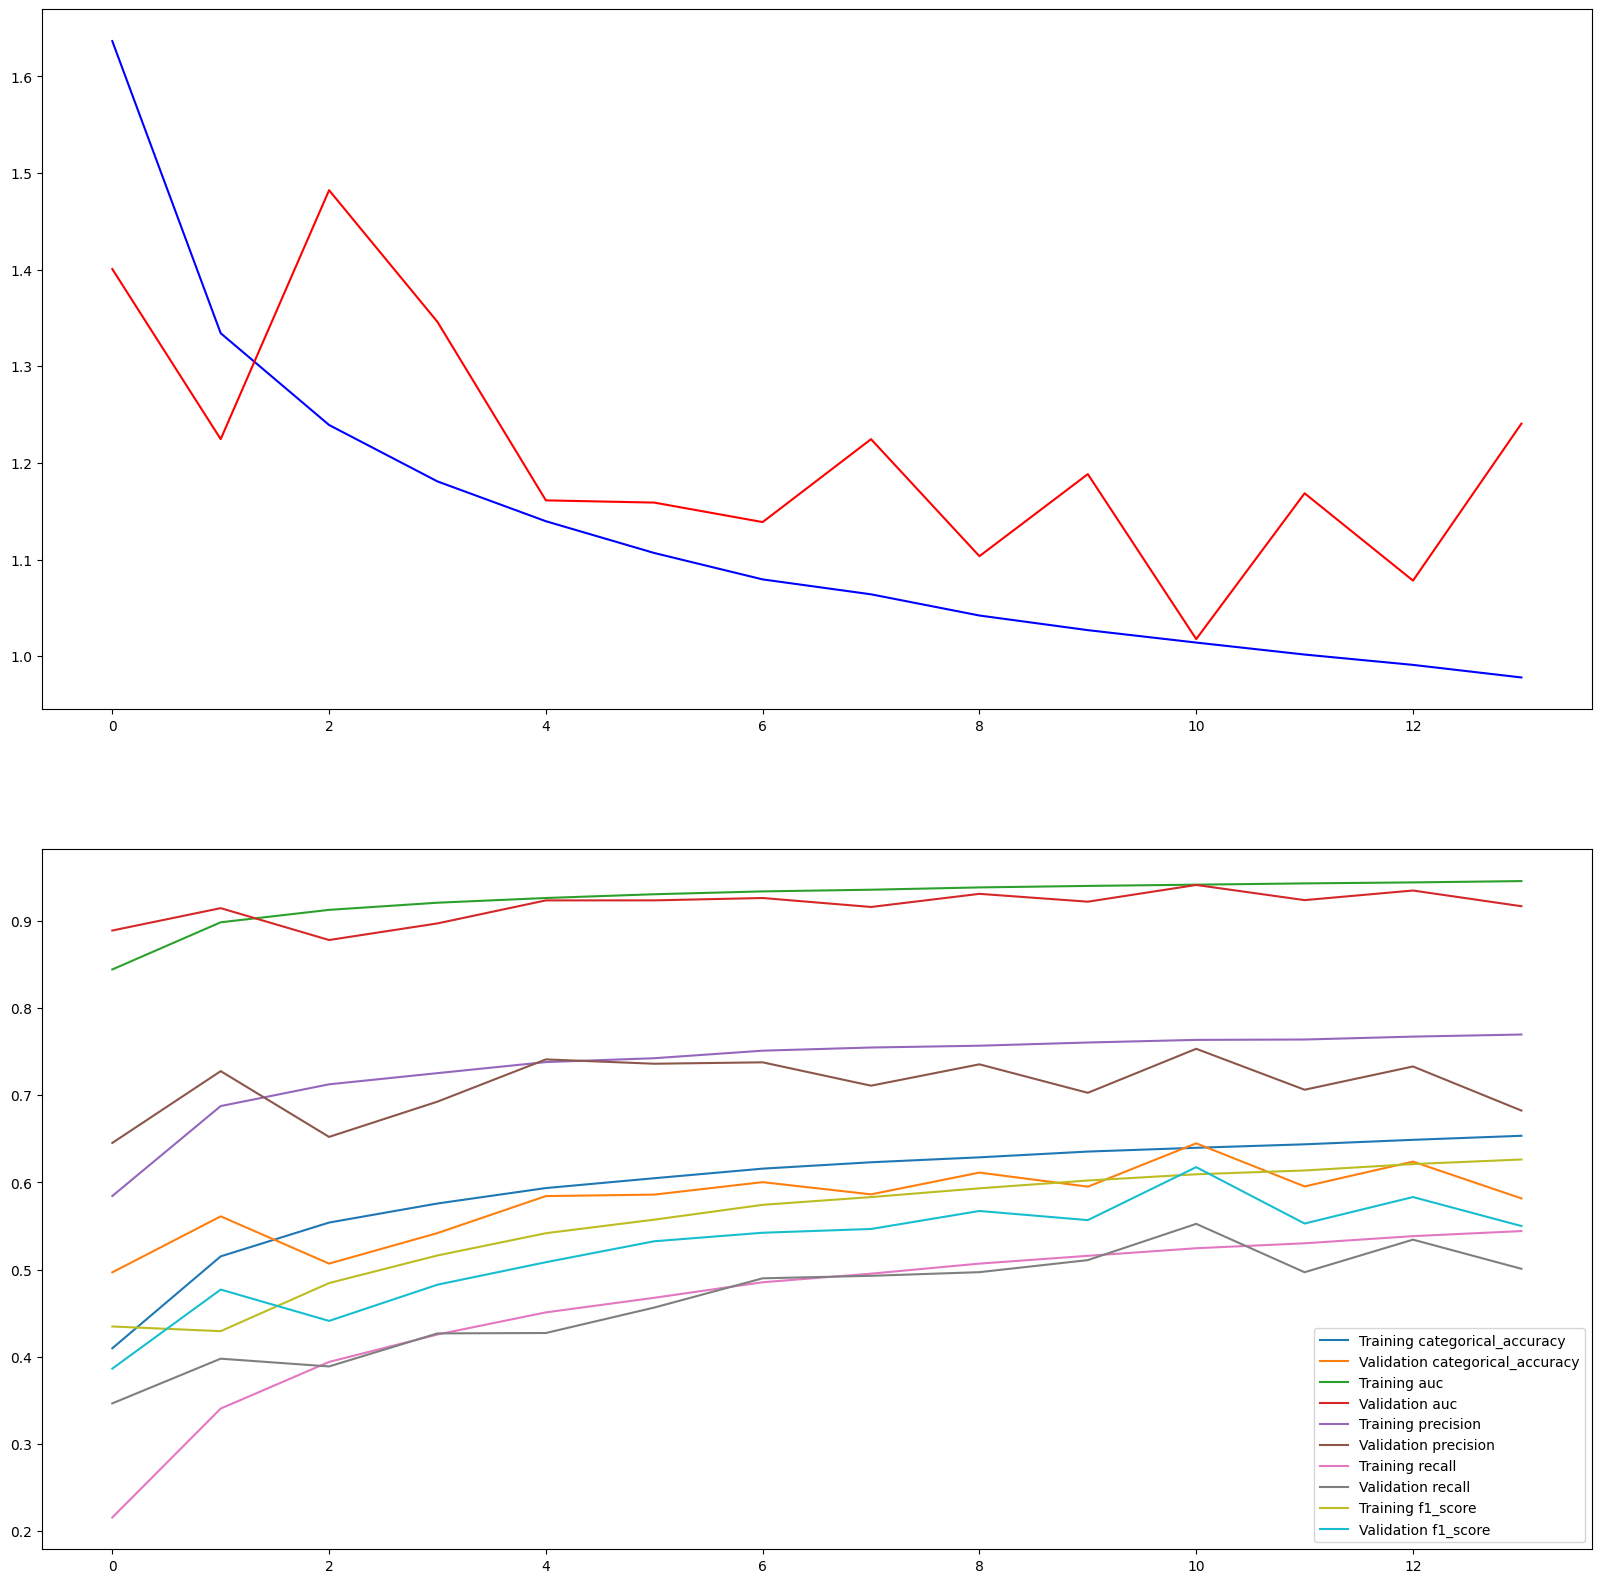

In [90]:
show_training_validation_loss_and_metrics(model13,metrics2)

In [91]:
model13.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.2475 - categorical_accuracy: 0.5816 - auc: 0.9156 - precision: 0.6810 - recall: 0.4998 - f1_score: 0.5492


[1.2475106716156006,
 0.5815777778625488,
 0.9155562520027161,
 0.6809512376785278,
 0.499833345413208,
 0.5491539835929871]

5625/5625 [==============================] - 21s 4ms/step


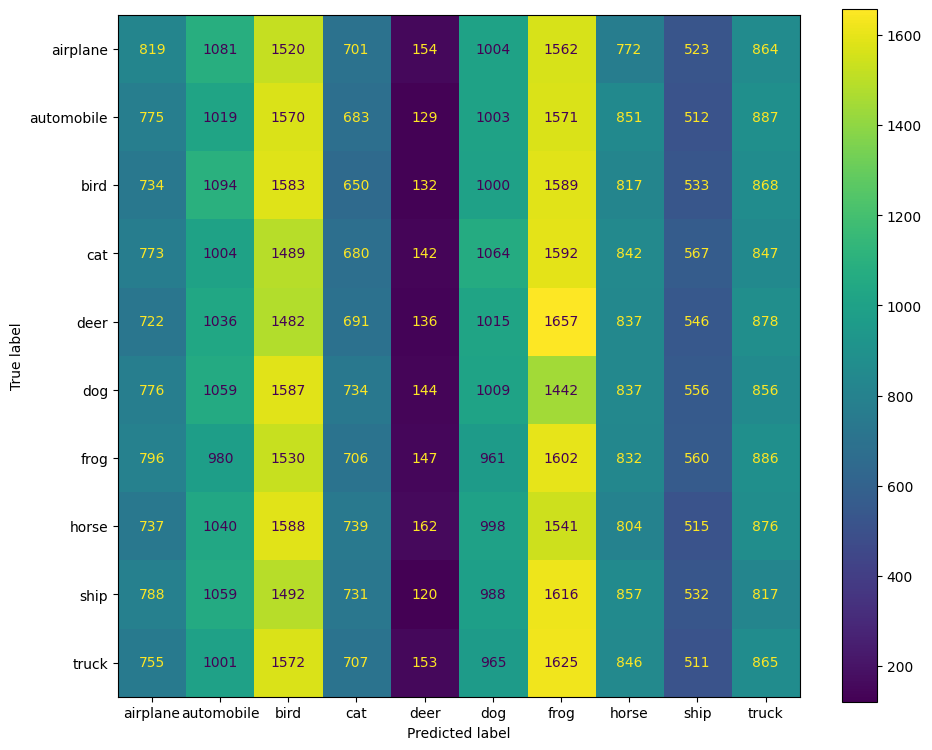

In [92]:
show_confusion_matrix(model13,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


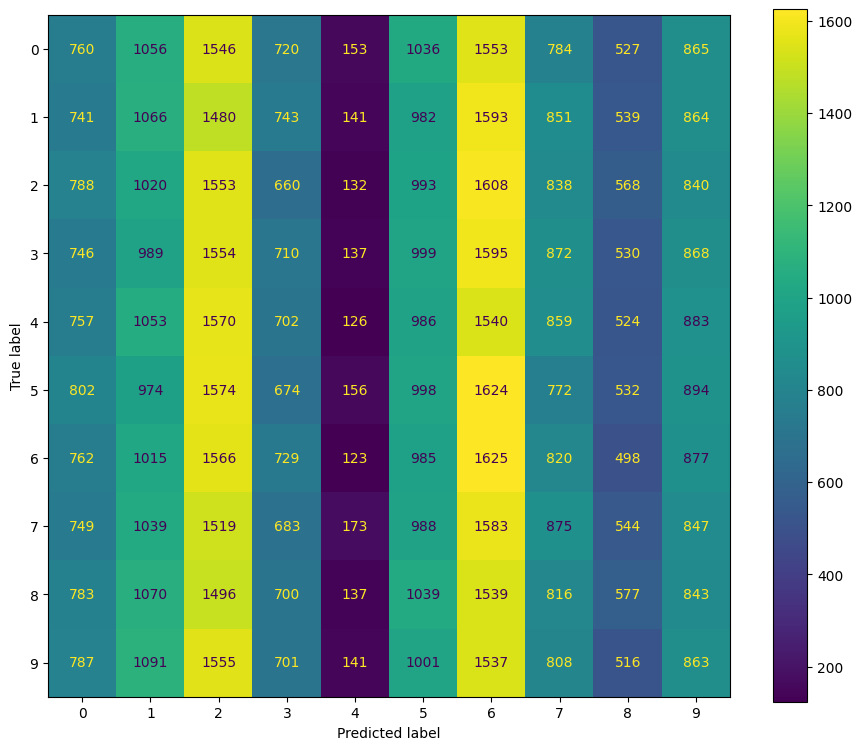

In [93]:
show_confusion_matrix_without_names(model13,test_ds,num_classes)

# Architektura drugiego modelu

In [94]:
model23 = create_model2(num_classes)

In [95]:
model23.compile( 
    loss=loss_func,
    metrics=metrics
)

In [96]:
model23.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_27 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_9 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_28 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [97]:
history = model23.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 121s 21ms/step - loss: 1.7746 - categorical_accuracy: 0.3528 - auc: 0.8097 - precision: 0.5817 - recall: 0.1192 - f1_score: 0.4015 - val_loss: 1.5539 - val_categorical_accuracy: 0.4289 - val_auc: 0.8609 - val_precision: 0.5944 - val_recall: 0.2504 - val_f1_score: 0.2989
Epoch 2/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.4940 - categorical_accuracy: 0.4525 - auc: 0.8706 - precision: 0.6546 - recall: 0.2325 - f1_score: 0.3139 - val_loss: 1.4151 - val_categorical_accuracy: 0.4811 - val_auc: 0.8849 - val_precision: 0.6821 - val_recall: 0.2715 - val_f1_score: 0.3331
Epoch 3/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.4031 - categorical_accuracy: 0.4906 - auc: 0.8867 - precision: 0.6806 - recall: 0.2854 - f1_score: 0.3728 - val_loss: 1.3394 - val_categorical_accuracy: 0.5084 - val_auc: 0.8973 - val_precision: 0.6926 - val_recall: 0.3167 - val_f1_score: 0.3915
Epoch 4/20
5625/562

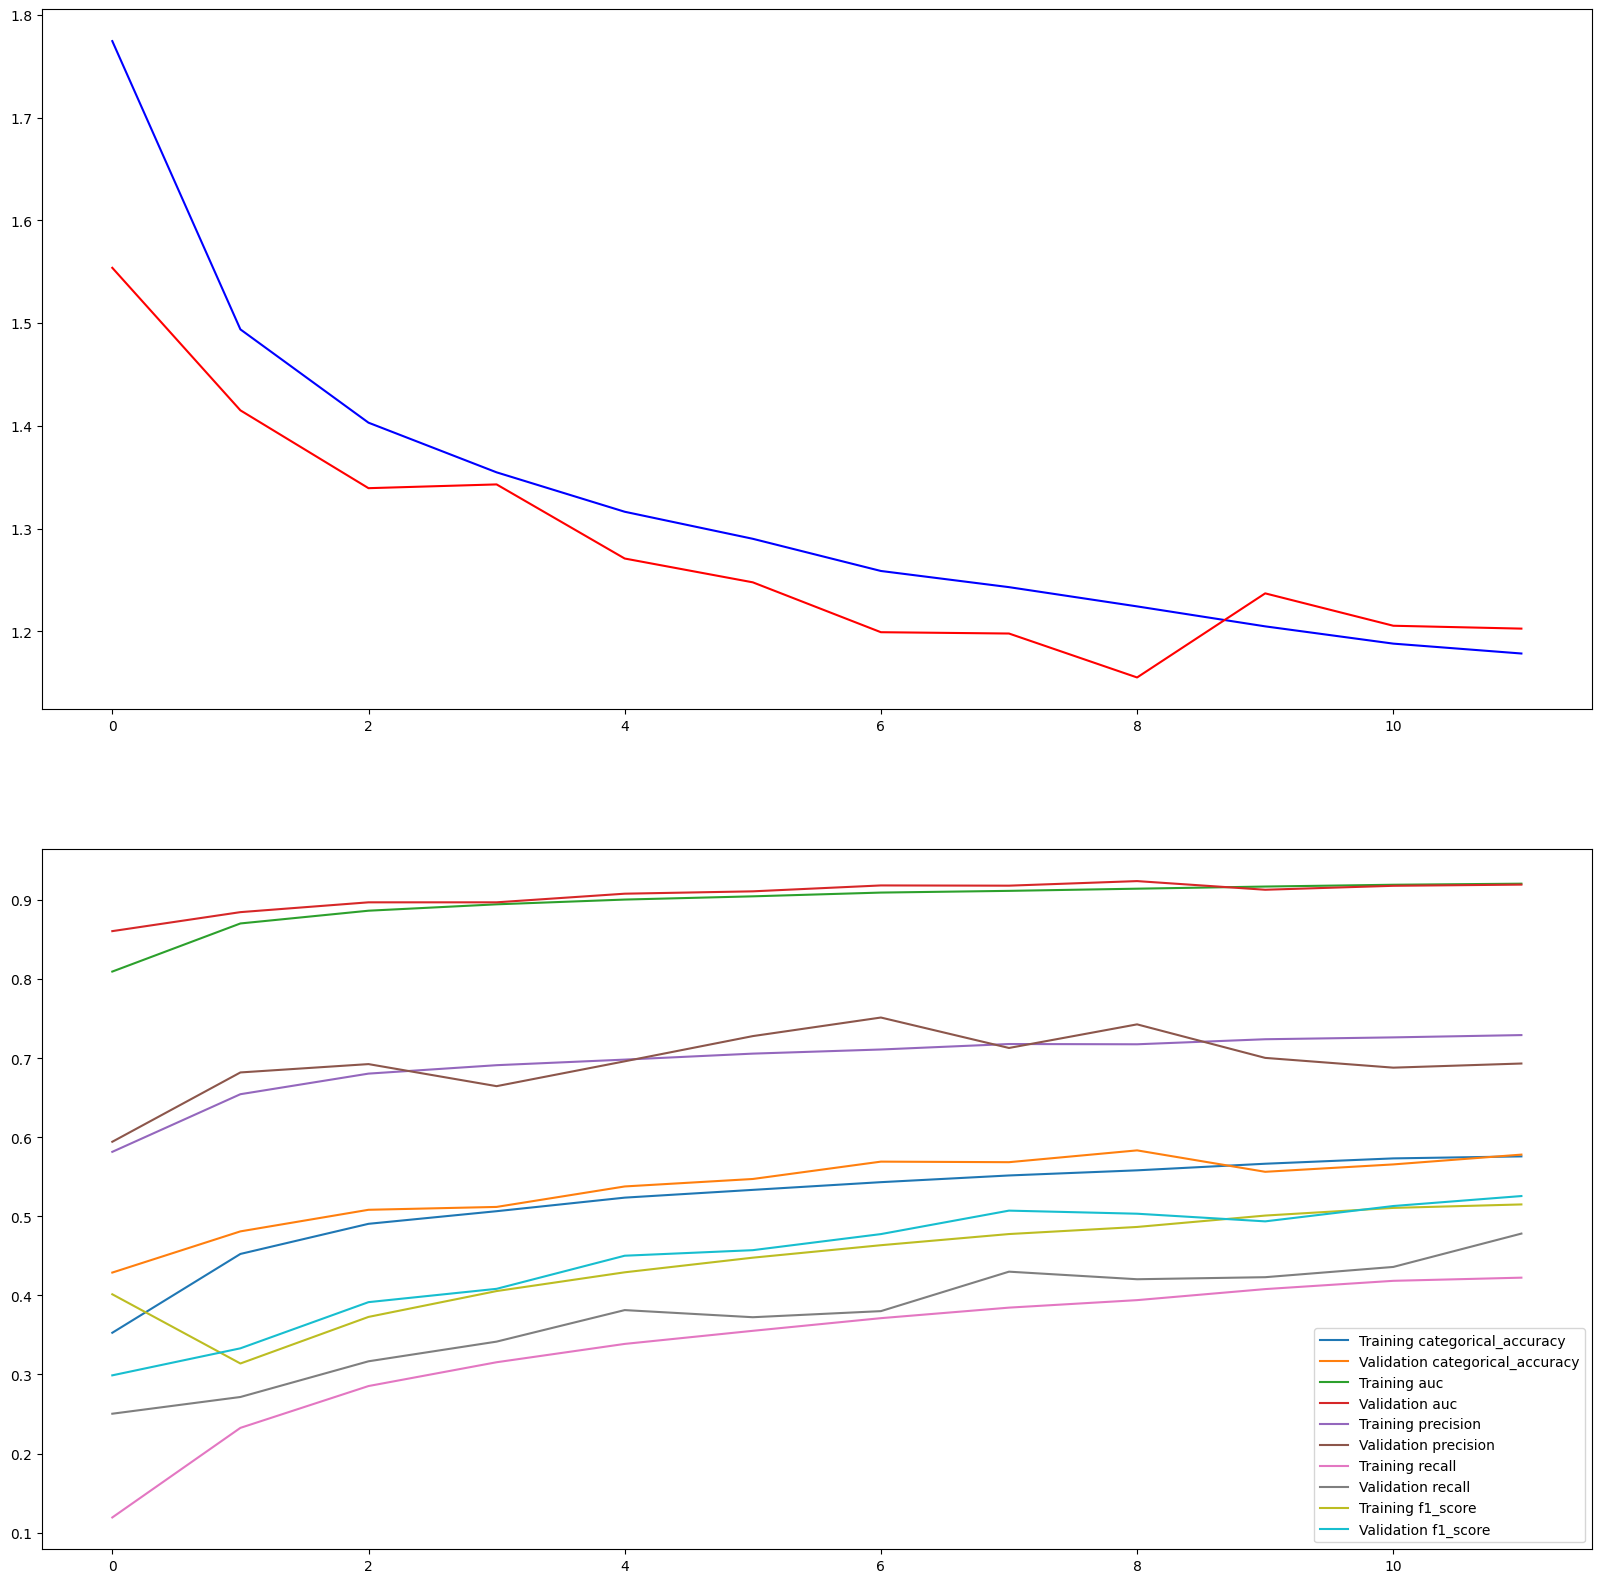

In [98]:
show_training_validation_loss_and_metrics(model23,metrics2)

In [99]:
model23.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.2089 - categorical_accuracy: 0.5781 - auc: 0.9188 - precision: 0.6927 - recall: 0.4767 - f1_score: 0.5240


[1.208930253982544,
 0.5781000256538391,
 0.9188224673271179,
 0.6926690936088562,
 0.47673332691192627,
 0.5239890217781067]

5625/5625 [==============================] - 22s 4ms/step


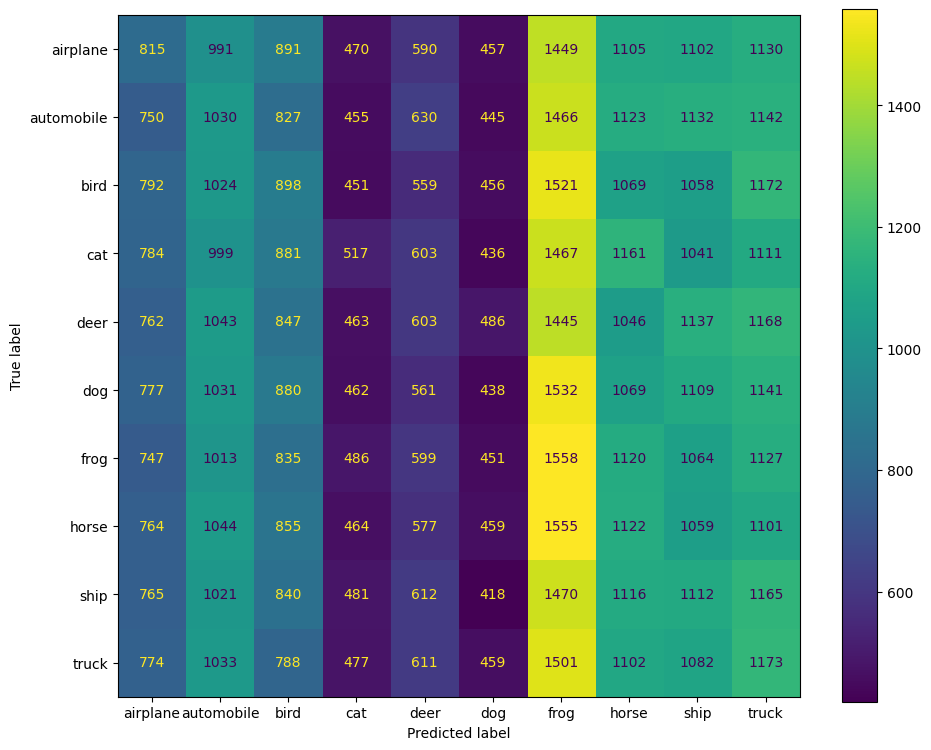

In [100]:
show_confusion_matrix(model23,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


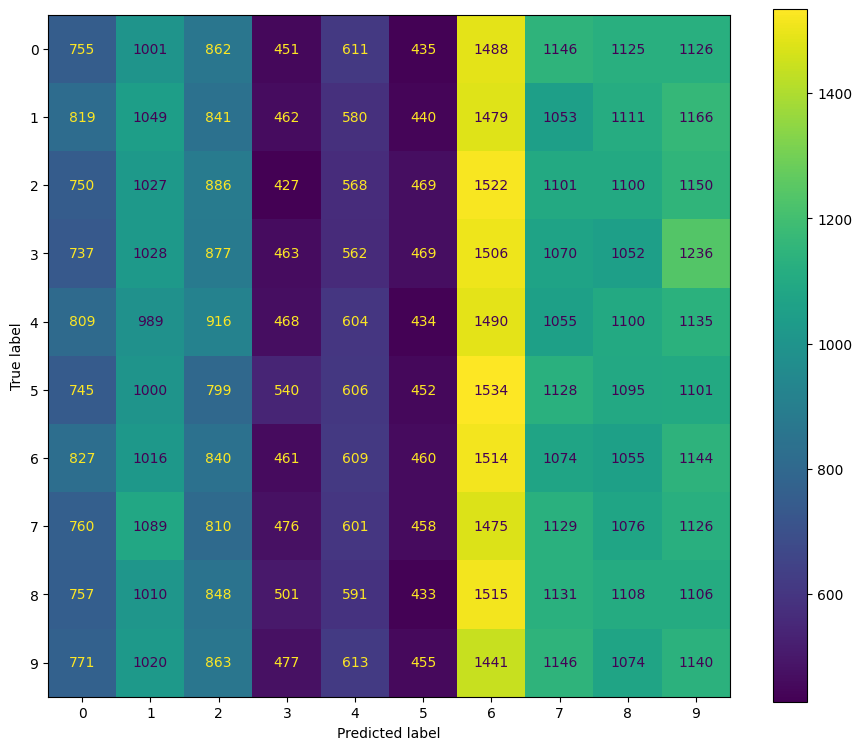

In [101]:
show_confusion_matrix_without_names(model23,test_ds,num_classes)

# Architektura trzeciego modelu

In [102]:
model33 = create_model3(num_classes)

model33.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [103]:
history = model33.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 121s 21ms/step - loss: 1.7413 - categorical_accuracy: 0.3448 - auc: 0.8149 - precision: 0.6115 - recall: 0.1033 - f1_score: 0.3774 - val_loss: 1.5945 - val_categorical_accuracy: 0.4095 - val_auc: 0.8528 - val_precision: 0.5717 - val_recall: 0.2436 - val_f1_score: 0.2790
Epoch 2/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.4776 - categorical_accuracy: 0.4538 - auc: 0.8735 - precision: 0.6625 - recall: 0.2338 - f1_score: 0.3105 - val_loss: 1.3806 - val_categorical_accuracy: 0.4859 - val_auc: 0.8916 - val_precision: 0.6430 - val_recall: 0.3167 - val_f1_score: 0.3608
Epoch 3/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.3794 - categorical_accuracy: 0.4934 - auc: 0.8909 - precision: 0.6859 - recall: 0.2943 - f1_score: 0.3745 - val_loss: 1.3423 - val_categorical_accuracy: 0.5060 - val_auc: 0.8973 - val_precision: 0.6684 - val_recall: 0.3479 - val_f1_score: 0.3920
Epoch 4/20
5625/562

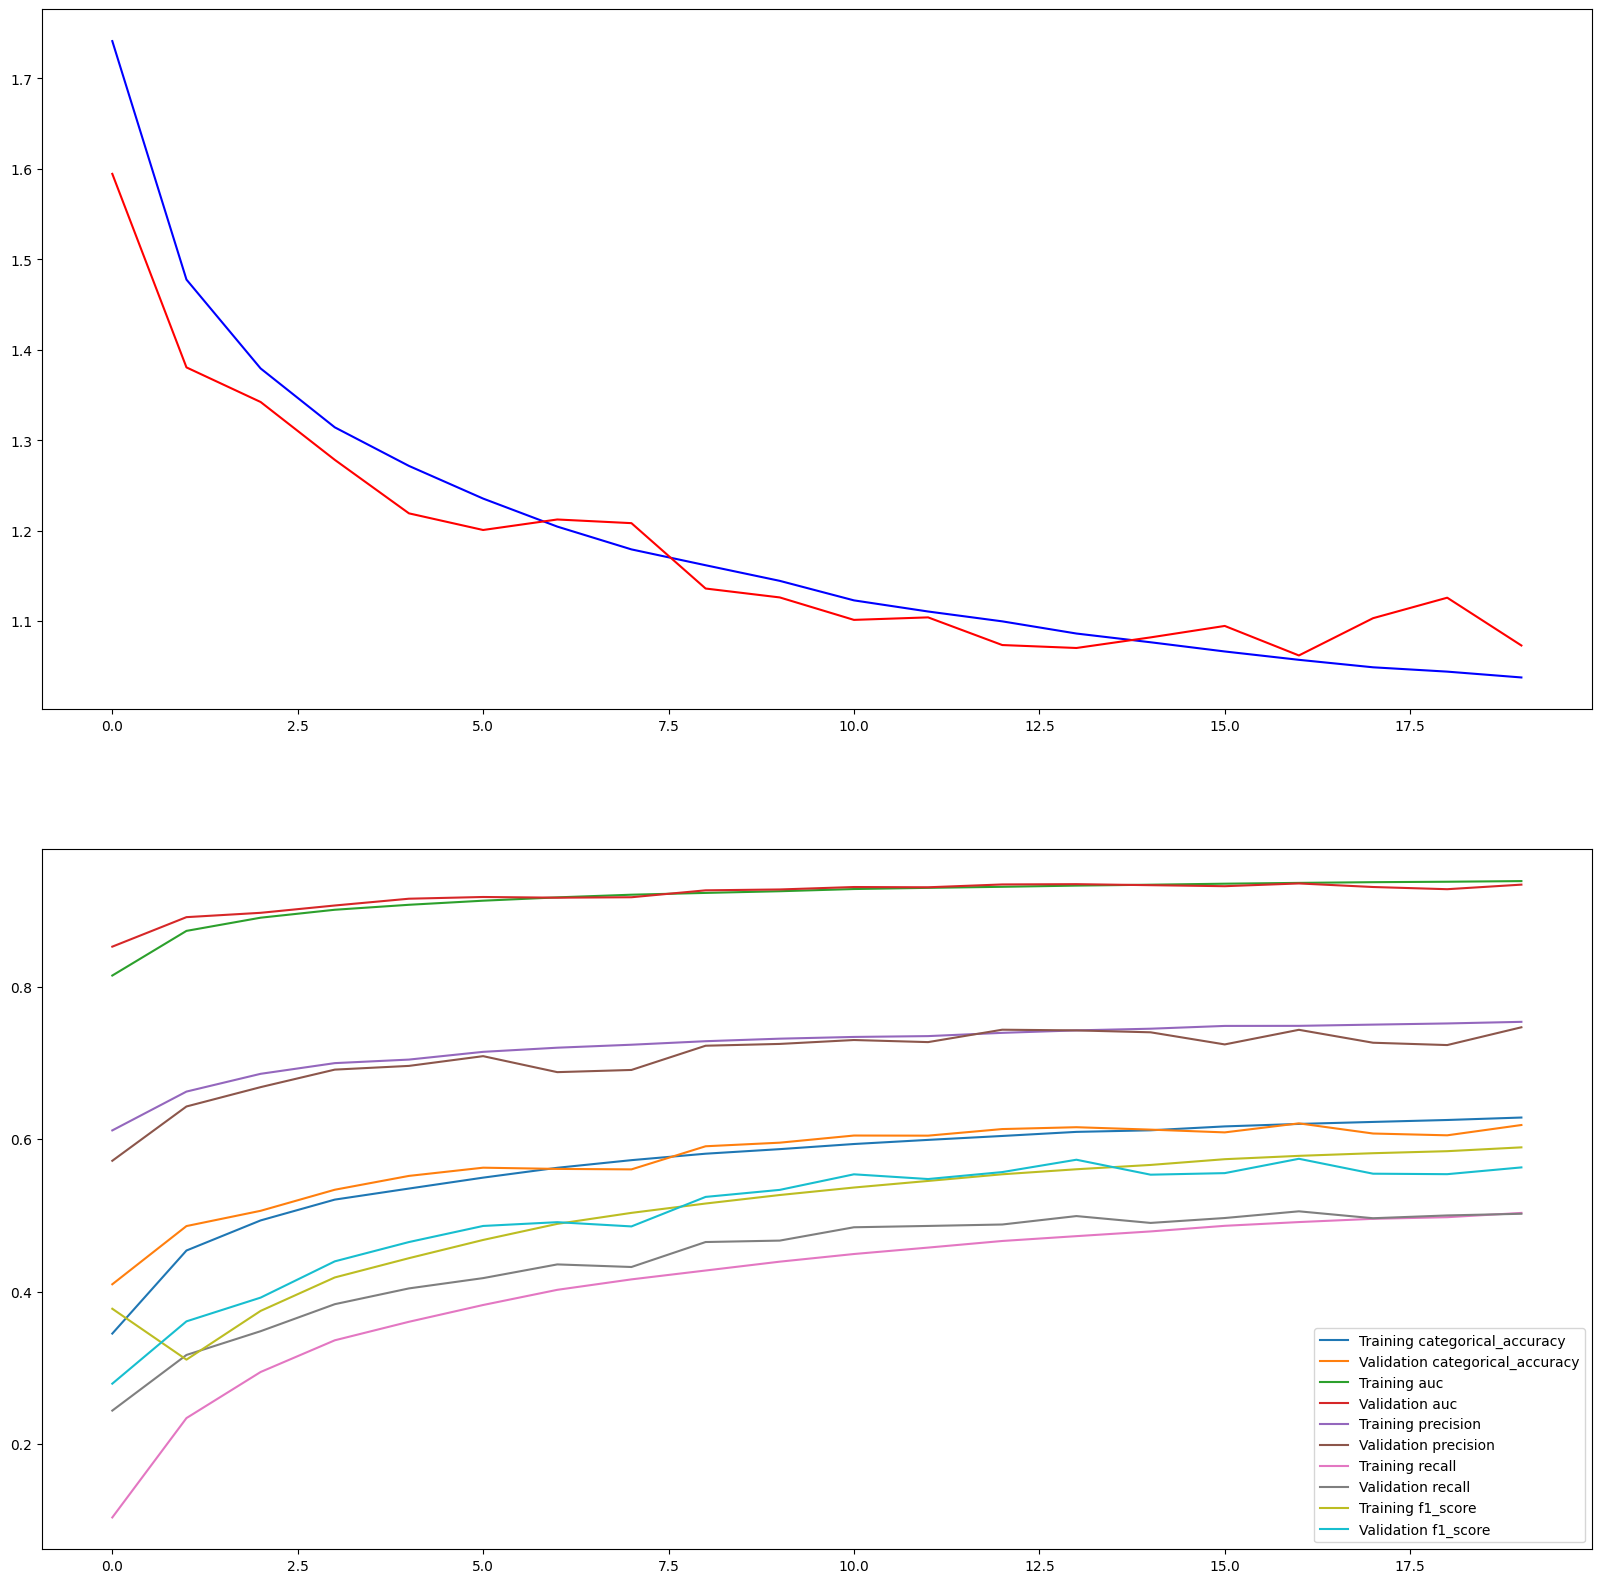

In [104]:
show_training_validation_loss_and_metrics(model33,metrics2)

In [105]:
model33.evaluate(test_it)

5625/5625 [==============================] - 46s 8ms/step - loss: 1.0830 - categorical_accuracy: 0.6147 - auc: 0.9331 - precision: 0.7434 - recall: 0.4996 - f1_score: 0.5610


[1.0829782485961914,
 0.6146666407585144,
 0.9331014156341553,
 0.7434282302856445,
 0.4996333420276642,
 0.5609636306762695]

5625/5625 [==============================] - 22s 4ms/step


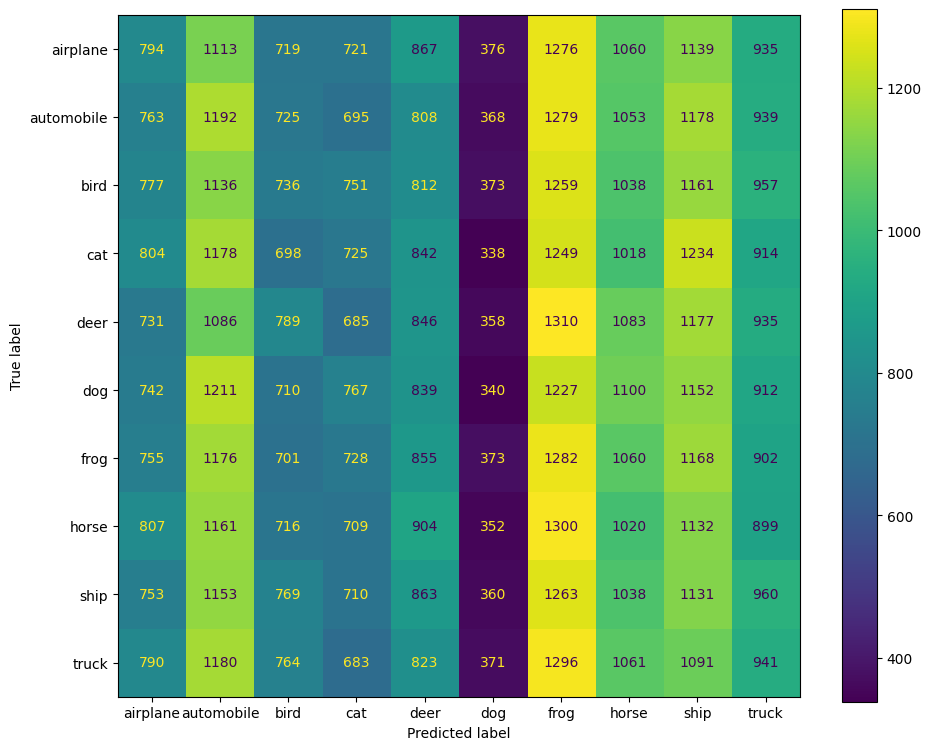

In [106]:
show_confusion_matrix(model33,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


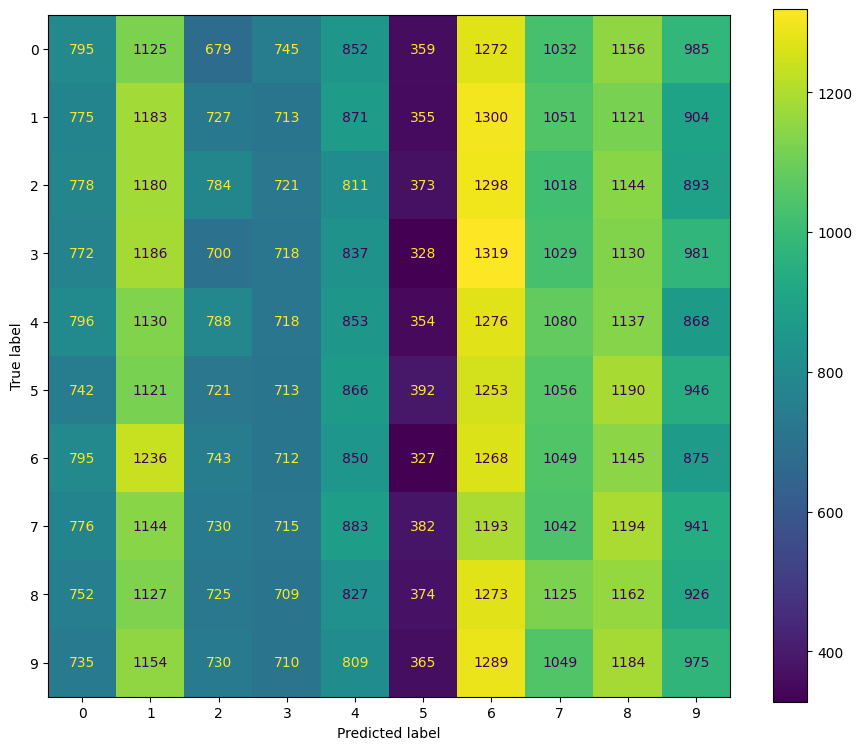

In [107]:
show_confusion_matrix_without_names(model33,test_ds,num_classes)

# Ziarno 313

In [108]:
SEED = 313
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [109]:
model14 = create_model1(num_classes)

In [110]:
model14.compile( 
    loss=loss_func,
    metrics=metrics
)

In [111]:
model14.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                     

In [112]:
history = model14.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.6304 - categorical_accuracy: 0.4089 - auc: 0.8456 - precision: 0.5873 - recall: 0.2160 - f1_score: 0.4421 - val_loss: 1.3768 - val_categorical_accuracy: 0.4980 - val_auc: 0.8919 - val_precision: 0.6578 - val_recall: 0.3388 - val_f1_score: 0.4116
Epoch 2/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.3305 - categorical_accuracy: 0.5183 - auc: 0.8987 - precision: 0.6896 - recall: 0.3426 - f1_score: 0.4318 - val_loss: 1.4030 - val_categorical_accuracy: 0.4950 - val_auc: 0.8861 - val_precision: 0.6772 - val_recall: 0.3241 - val_f1_score: 0.3908
Epoch 3/20
5625/5625 [==============================] - 119s 21ms/step - loss: 1.2353 - categorical_accuracy: 0.5560 - auc: 0.9129 - precision: 0.7156 - recall: 0.3969 - f1_score: 0.4881 - val_loss: 1.3043 - val_categorical_accuracy: 0.5404 - val_auc: 0.9058 - val_precision: 0.6618 - val_recall: 0.4357 - val_f1_score: 0.4753
Epoch 4/20
5625/562

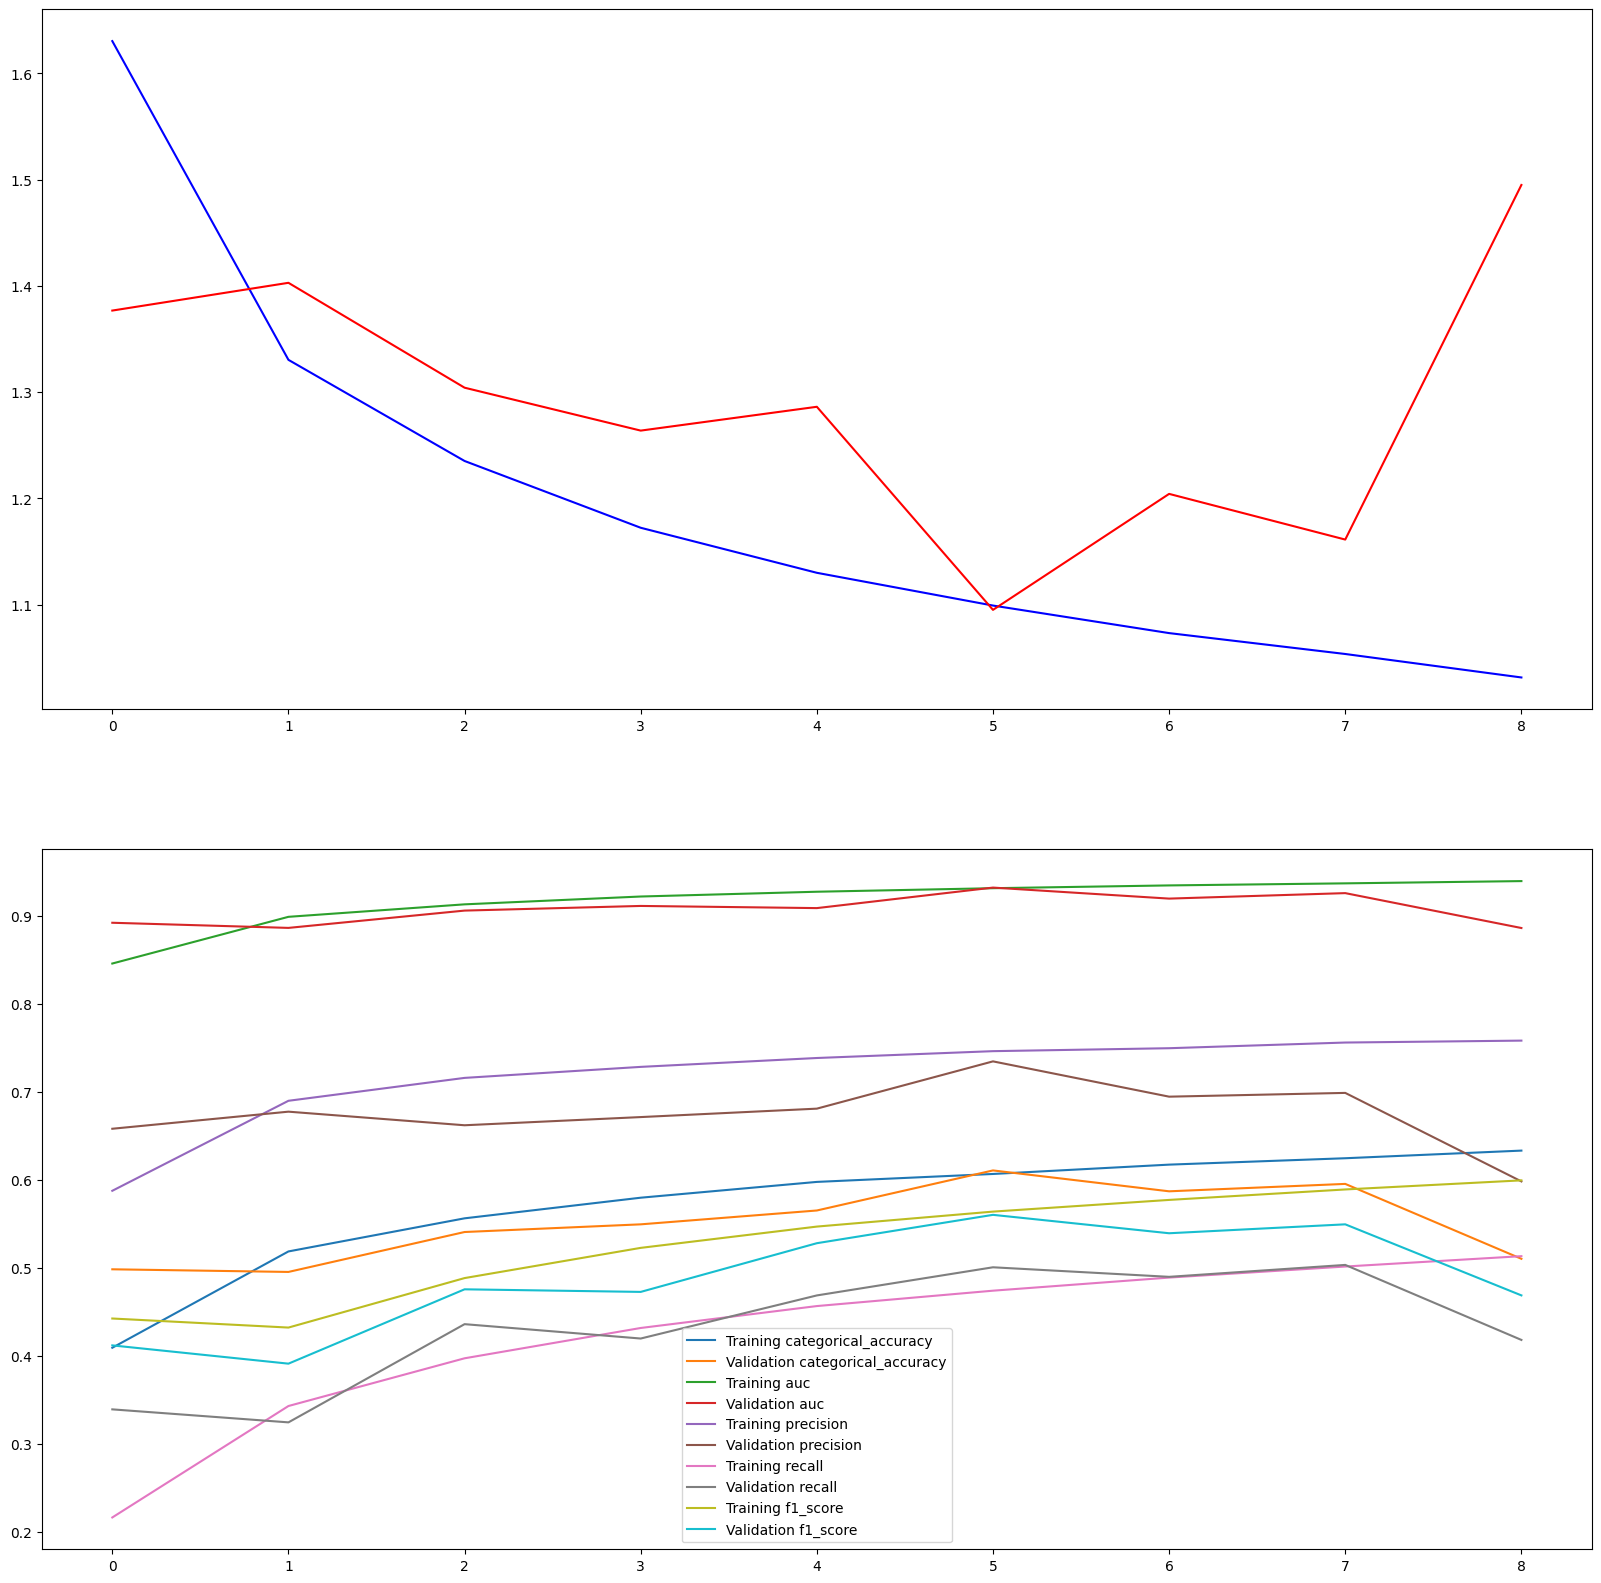

In [113]:
show_training_validation_loss_and_metrics(model14,metrics2)

In [114]:
model14.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.5015 - categorical_accuracy: 0.5080 - auc: 0.8853 - precision: 0.5969 - recall: 0.4178 - f1_score: 0.4688


[1.5014519691467285,
 0.5079777836799622,
 0.8852934241294861,
 0.5968602299690247,
 0.41778889298439026,
 0.46881961822509766]

5625/5625 [==============================] - 21s 4ms/step


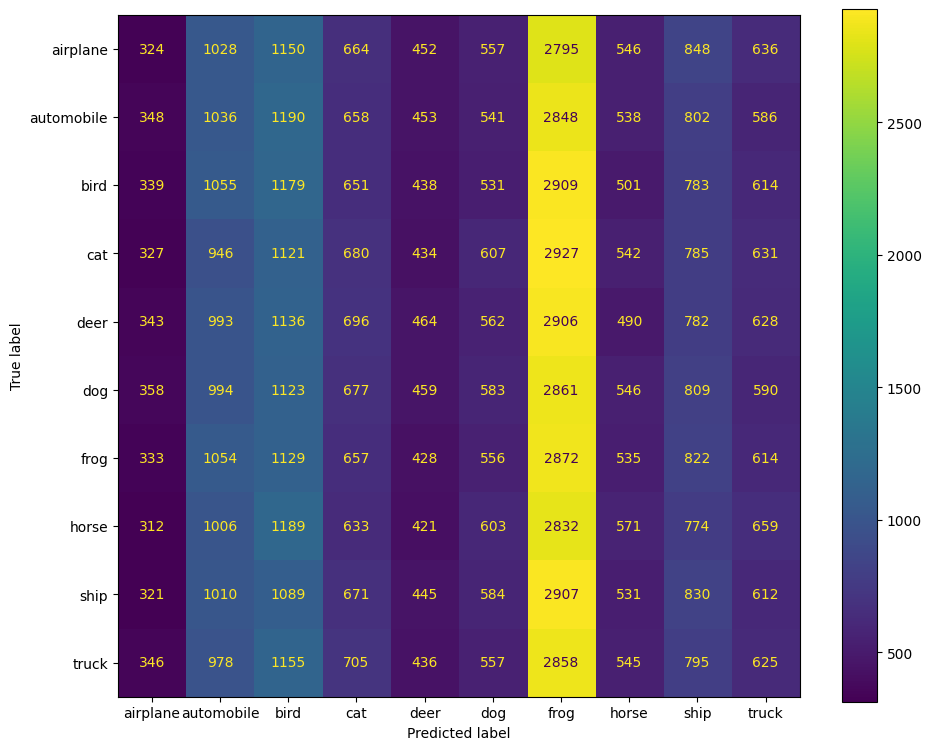

In [115]:
show_confusion_matrix(model14,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


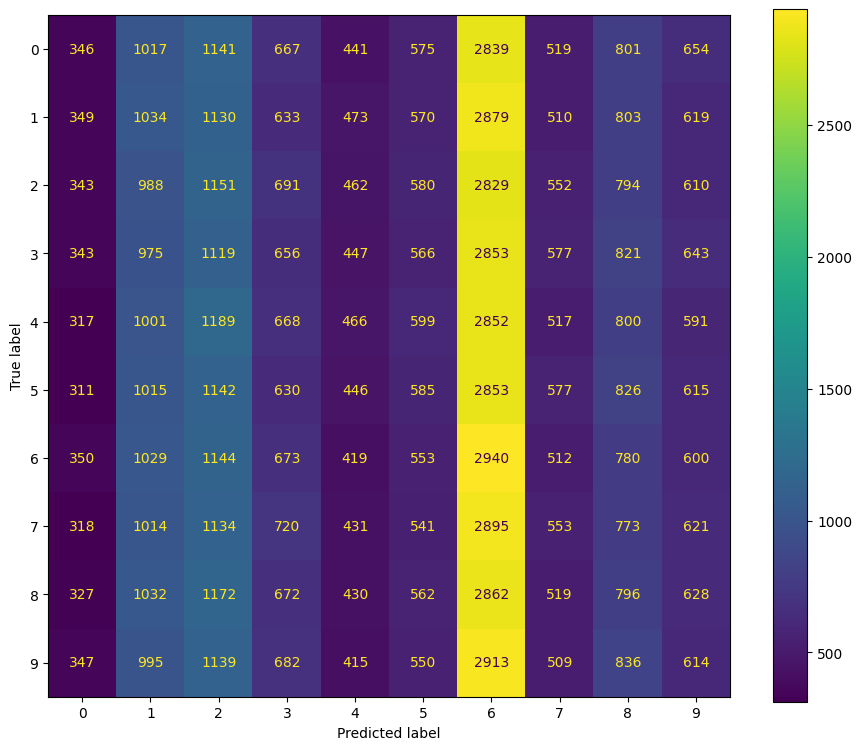

In [116]:
show_confusion_matrix_without_names(model14,test_ds,num_classes)

# Architektura drugiego modelu

In [117]:
model24 = create_model2(num_classes)

In [118]:
model24.compile( 
    loss=loss_func,
    metrics=metrics
)

In [119]:
model24.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_36 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_12 (Avera  (None, 16, 16, 75)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_37 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [120]:
history = model24.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 123s 22ms/step - loss: 1.7741 - categorical_accuracy: 0.3561 - auc: 0.8093 - precision: 0.5878 - recall: 0.1199 - f1_score: 0.3506 - val_loss: 1.5334 - val_categorical_accuracy: 0.4269 - val_auc: 0.8643 - val_precision: 0.5974 - val_recall: 0.2535 - val_f1_score: 0.2941
Epoch 2/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.4930 - categorical_accuracy: 0.4540 - auc: 0.8706 - precision: 0.6636 - recall: 0.2365 - f1_score: 0.3187 - val_loss: 1.3993 - val_categorical_accuracy: 0.4908 - val_auc: 0.8868 - val_precision: 0.6943 - val_recall: 0.2914 - val_f1_score: 0.3598
Epoch 3/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.4087 - categorical_accuracy: 0.4880 - auc: 0.8857 - precision: 0.6827 - recall: 0.2864 - f1_score: 0.3736 - val_loss: 1.3976 - val_categorical_accuracy: 0.4984 - val_auc: 0.8880 - val_precision: 0.6768 - val_recall: 0.3386 - val_f1_score: 0.4069
Epoch 4/20
5625/562

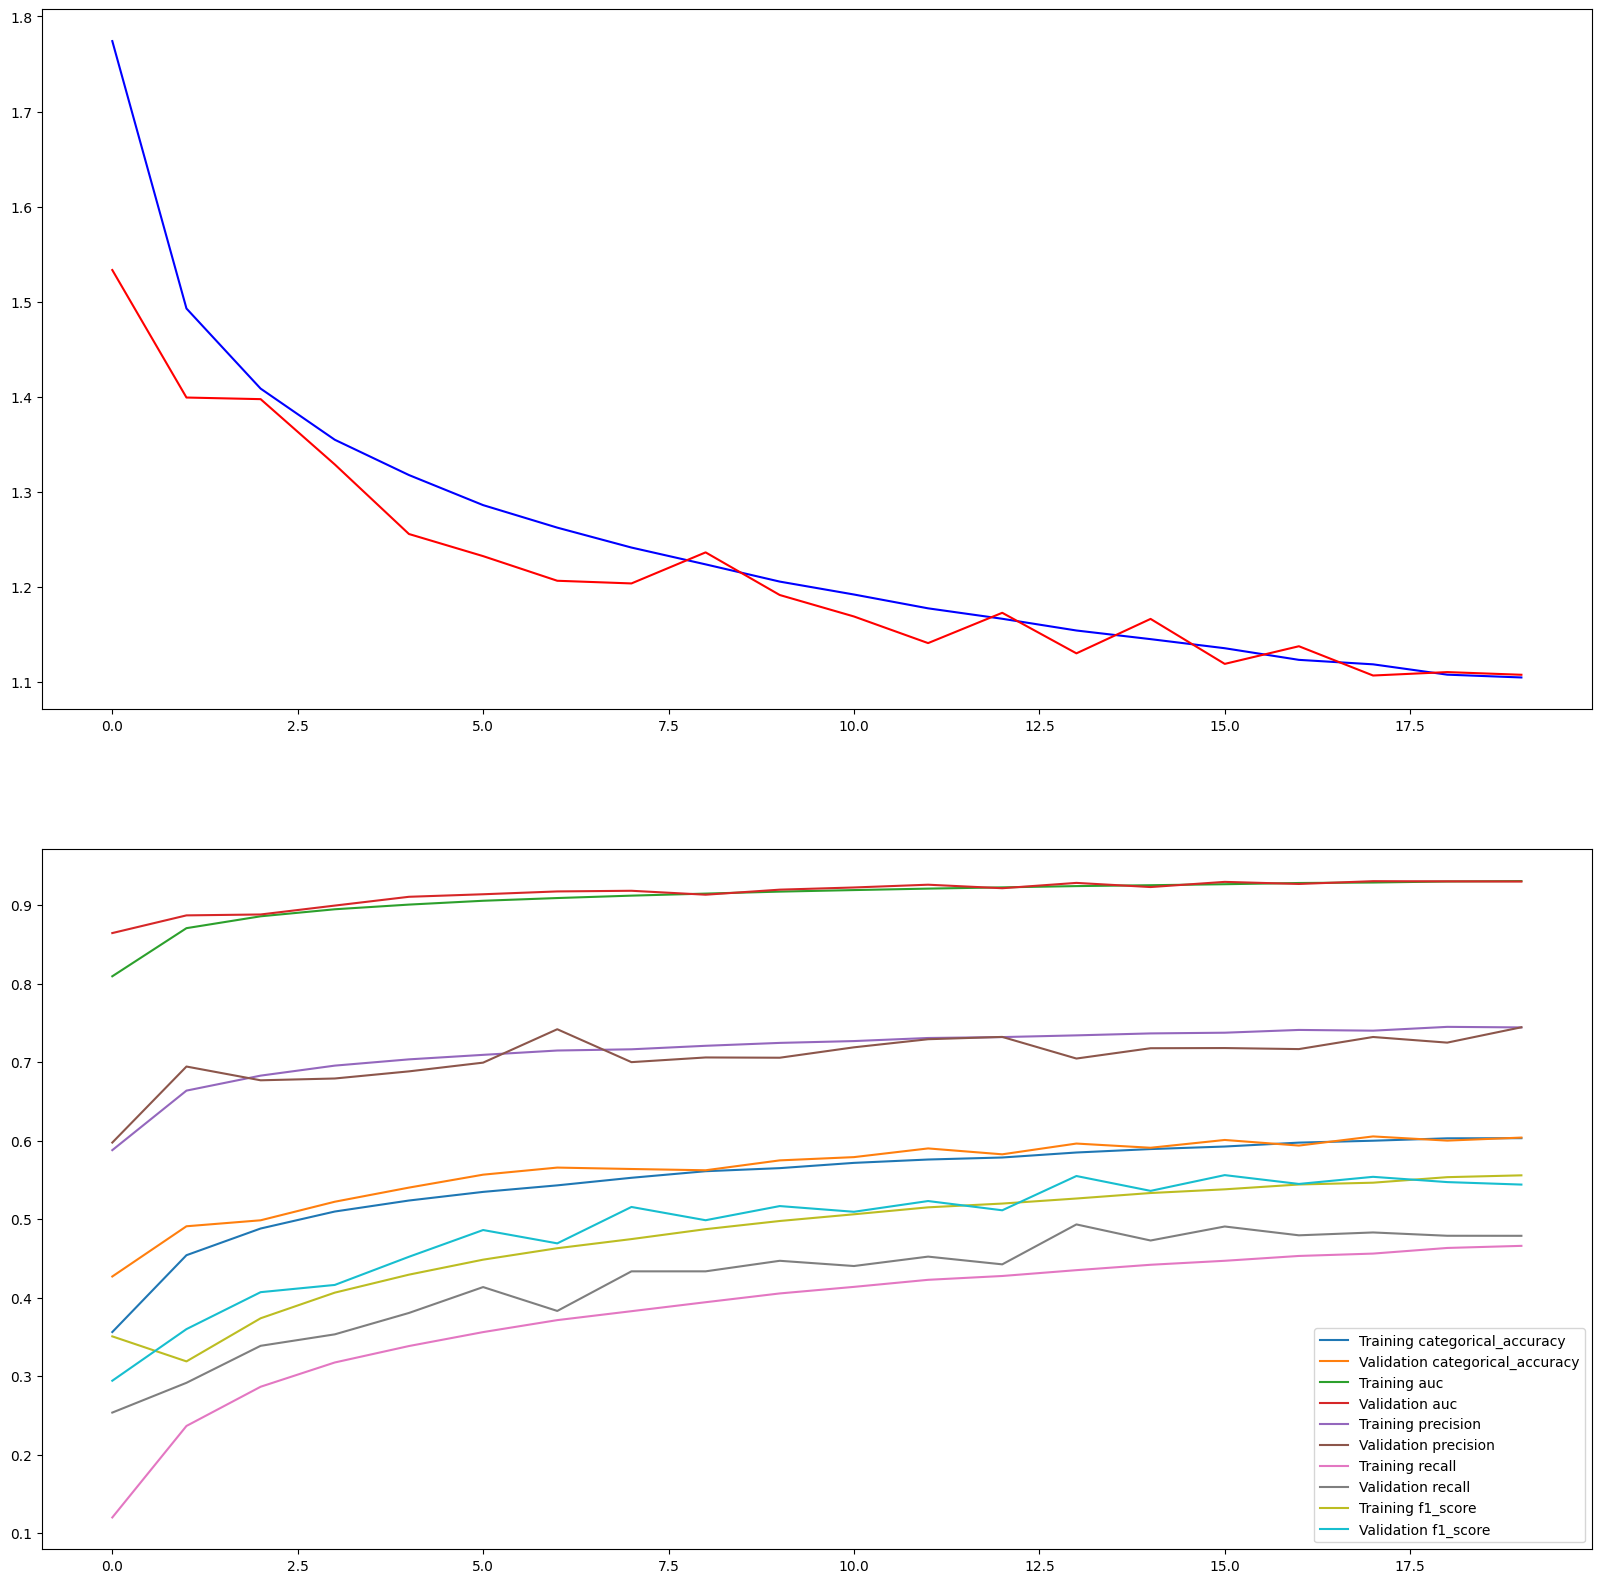

In [121]:
show_training_validation_loss_and_metrics(model24,metrics2)

In [122]:
model24.evaluate(test_it)

5625/5625 [==============================] - 47s 8ms/step - loss: 1.1191 - categorical_accuracy: 0.6014 - auc: 0.9285 - precision: 0.7433 - recall: 0.4771 - f1_score: 0.5435


[1.1191132068634033,
 0.6013777852058411,
 0.92847740650177,
 0.743301272392273,
 0.4771333336830139,
 0.5434705018997192]

5625/5625 [==============================] - 20s 4ms/step


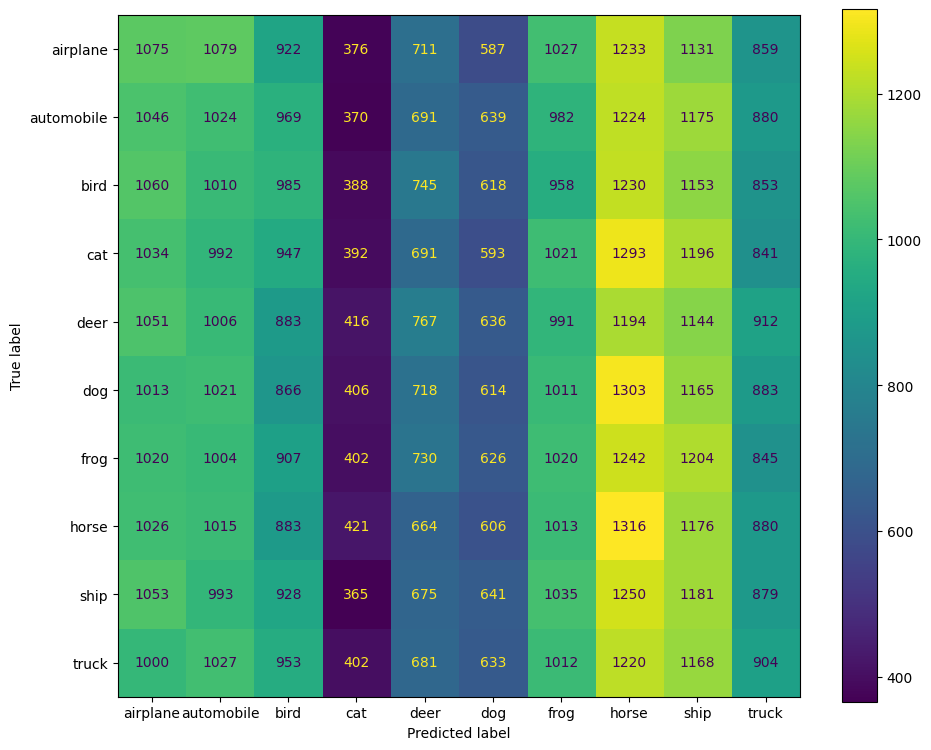

In [123]:
show_confusion_matrix(model24,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


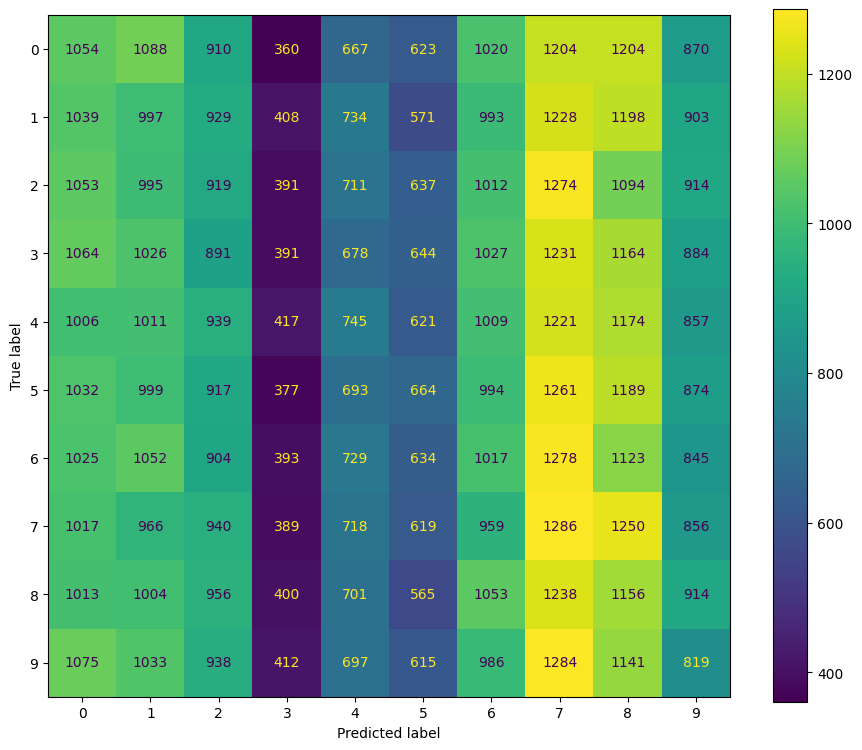

In [124]:
show_confusion_matrix_without_names(model24,test_ds,num_classes)

# Architektura trzeciego modelu

In [125]:
model34 = create_model3(num_classes)

model34.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [126]:
history = model34.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 123s 22ms/step - loss: 1.7208 - categorical_accuracy: 0.3531 - auc: 0.8206 - precision: 0.6120 - recall: 0.1092 - f1_score: 0.3881 - val_loss: 1.5318 - val_categorical_accuracy: 0.4308 - val_auc: 0.8639 - val_precision: 0.6164 - val_recall: 0.2437 - val_f1_score: 0.2920
Epoch 2/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.4735 - categorical_accuracy: 0.4537 - auc: 0.8743 - precision: 0.6580 - recall: 0.2383 - f1_score: 0.3152 - val_loss: 1.4021 - val_categorical_accuracy: 0.4797 - val_auc: 0.8874 - val_precision: 0.6471 - val_recall: 0.3085 - val_f1_score: 0.3519
Epoch 3/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.3727 - categorical_accuracy: 0.4940 - auc: 0.8919 - precision: 0.6860 - recall: 0.2975 - f1_score: 0.3783 - val_loss: 1.3009 - val_categorical_accuracy: 0.5246 - val_auc: 0.9034 - val_precision: 0.6905 - val_recall: 0.3506 - val_f1_score: 0.4125
Epoch 4/20
5625/562

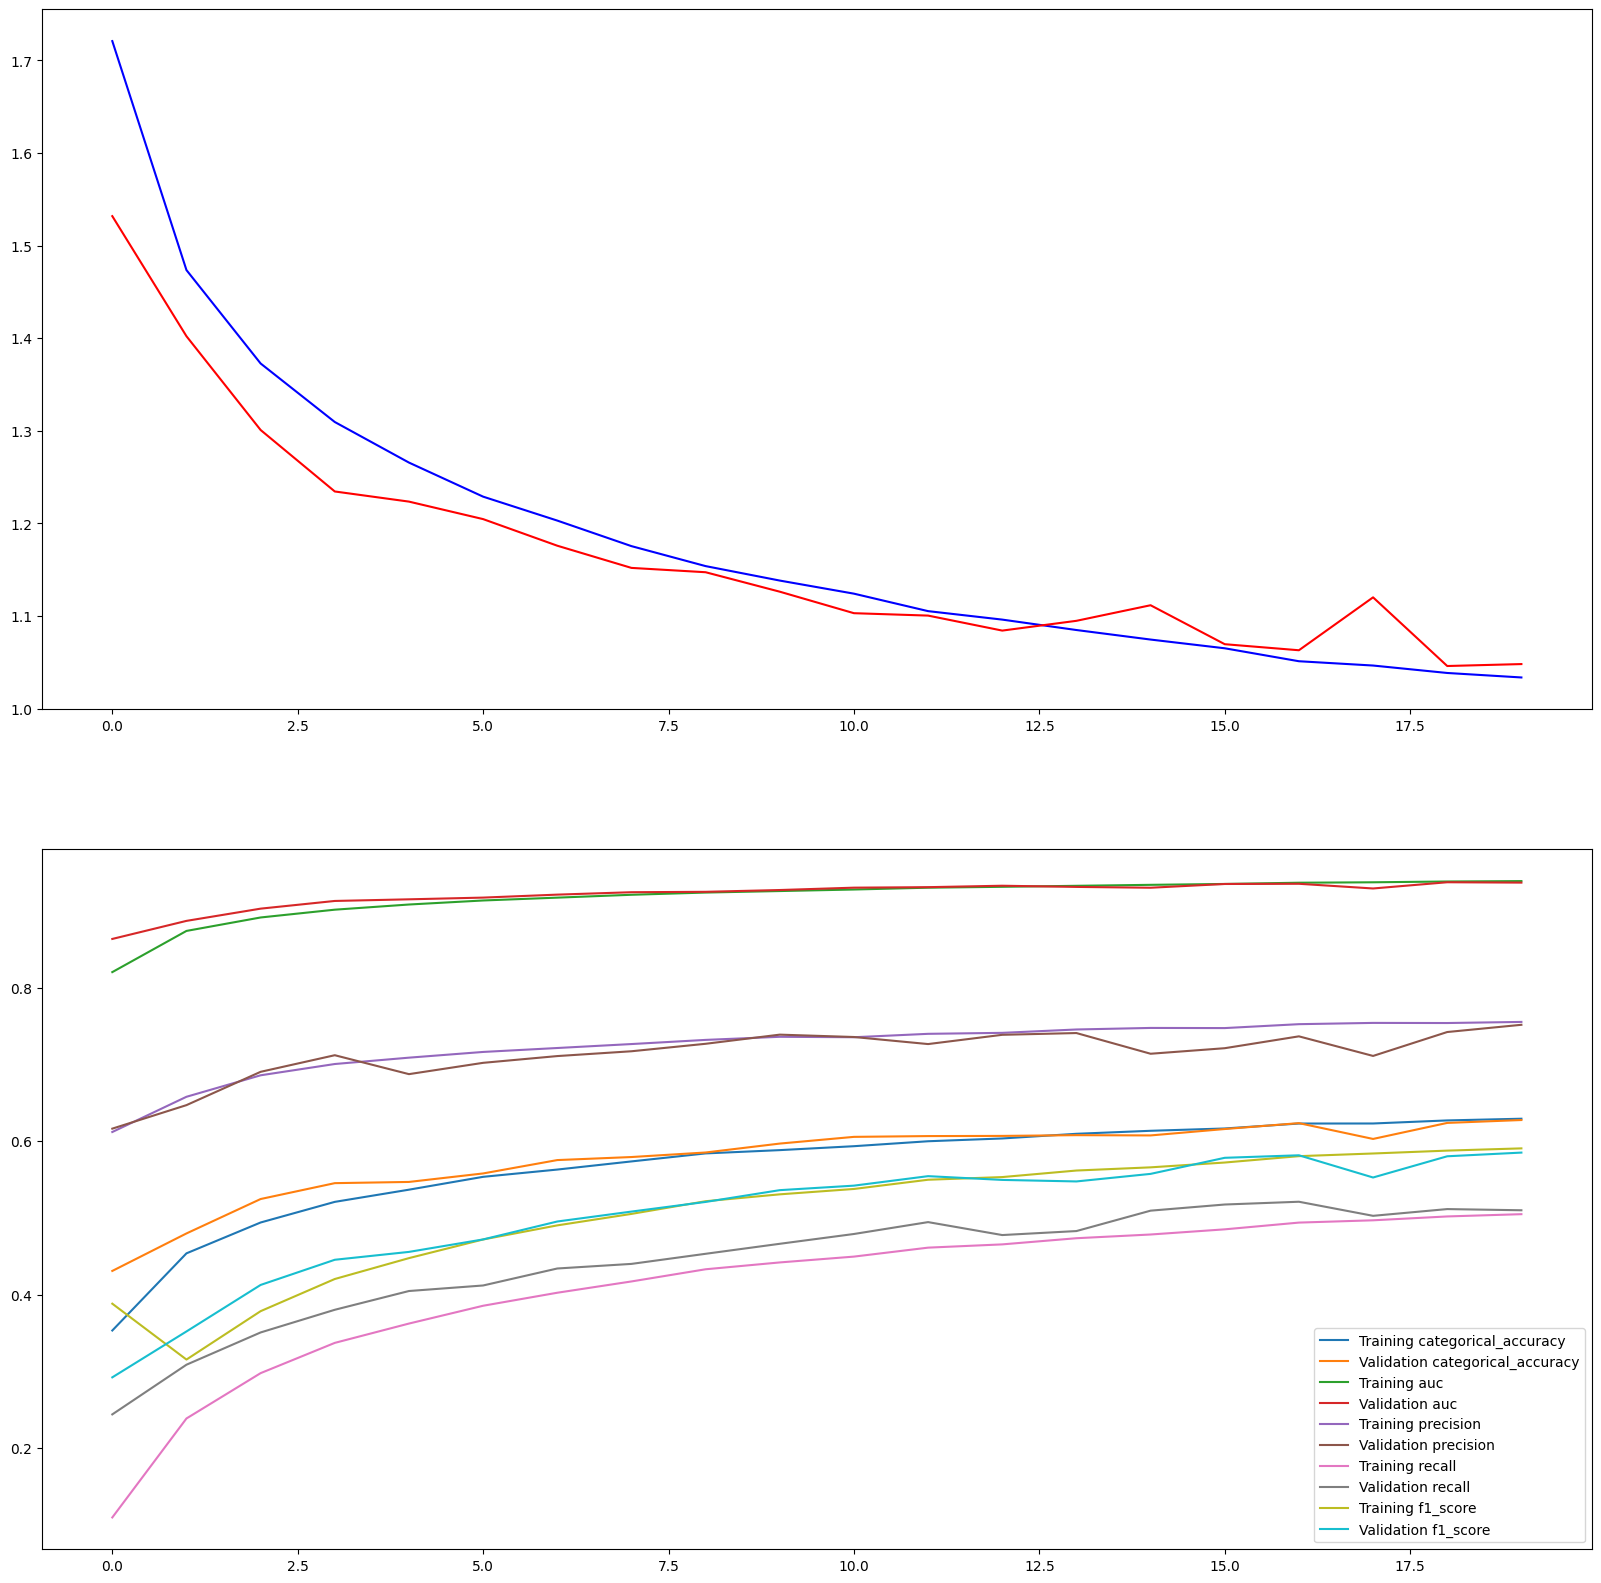

In [127]:
show_training_validation_loss_and_metrics(model34,metrics2)

In [128]:
model34.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.0563 - categorical_accuracy: 0.6268 - auc: 0.9362 - precision: 0.7523 - recall: 0.5104 - f1_score: 0.5864


[1.056330680847168,
 0.6267889142036438,
 0.9362077116966248,
 0.7523132562637329,
 0.5104110836982727,
 0.5863665342330933]

5625/5625 [==============================] - 22s 4ms/step


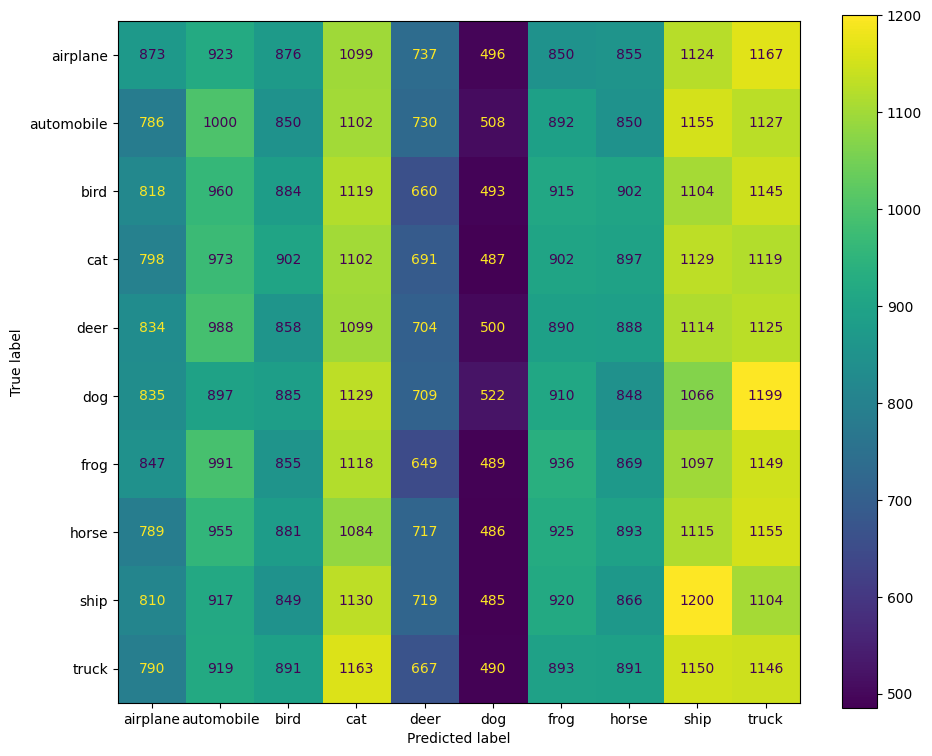

In [129]:
show_confusion_matrix(model34,test_ds,num_classes,class_names)

5625/5625 [==============================] - 23s 4ms/step


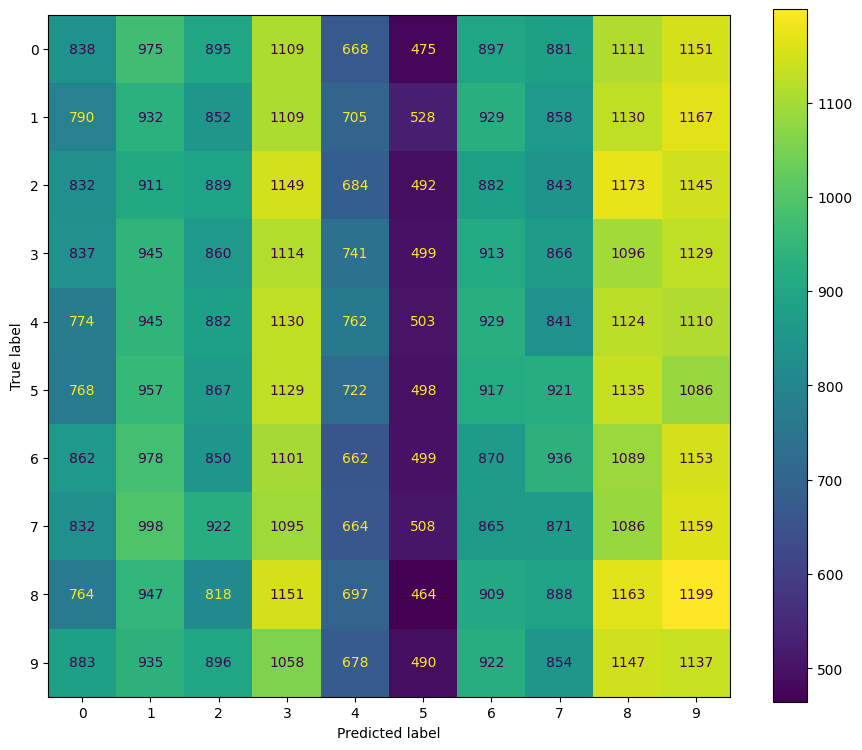

In [130]:
show_confusion_matrix_without_names(model34,test_ds,num_classes)